In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score

# Define the scoring metric with pos_label set to 'yes'
f1_scorer = make_scorer(f1_score, pos_label='yes')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# EDA

## Loading and cleaning the data

In [3]:
data=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [5]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
data.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [7]:
test_data=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')
test_data.isnull().sum()

last contact date       0
age                     0
job                    59
marital                 0
education             390
default                 0
balance                 0
housing                 0
loan                    0
contact              2684
duration                0
campaign                0
pdays                   0
previous                0
poutcome             7508
dtype: int64

In [8]:
data['pdays']=data['pdays'].replace(-1,0)

In [9]:
X_train=data.drop(['target'],axis=1)
Y_train=data['target']

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
dtypes: int64(6), object(9)
memory usage: 4.5+ MB


In [11]:
from sklearn.impute import SimpleImputer as si
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Cpipe=ColumnTransformer([("si",si(strategy="most_frequent"),["job","education","contact","poutcome"])],
                      remainder="passthrough")

X_train=pd.DataFrame(Cpipe.fit_transform(X_train),columns=['job','education','contact','poutcome','last contact date', 'age', 
                                                     'marital', 'default','balance', 'housing', 'loan', 'duration', 
                                                     'campaign','pdays', 'previous'])

In [12]:
X_train.columns

Index(['job', 'education', 'contact', 'poutcome', 'last contact date', 'age',
       'marital', 'default', 'balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                39211 non-null  object
 1   education          39211 non-null  object
 2   contact            39211 non-null  object
 3   poutcome           39211 non-null  object
 4   last contact date  39211 non-null  object
 5   age                39211 non-null  object
 6   marital            39211 non-null  object
 7   default            39211 non-null  object
 8   balance            39211 non-null  object
 9   housing            39211 non-null  object
 10  loan               39211 non-null  object
 11  duration           39211 non-null  object
 12  campaign           39211 non-null  object
 13  pdays              39211 non-null  object
 14  previous           39211 non-null  object
dtypes: object(15)
memory usage: 4.5+ MB


In [14]:
print(X_train)

                job  education    contact poutcome last contact date age  \
0       blue-collar  secondary   cellular    other        2009-04-17  26   
1        technician  secondary  telephone  failure        2009-10-11  52   
2       blue-collar  secondary   cellular  failure        2010-11-20  44   
3            admin.  secondary  telephone  failure        2009-09-01  33   
4      entrepreneur   tertiary   cellular  failure        2008-01-29  31   
...             ...        ...        ...      ...               ...  ..   
39206    technician  secondary   cellular  failure        2008-07-31  31   
39207        admin.    primary   cellular  failure        2009-07-31  59   
39208   blue-collar  secondary   cellular  failure        2008-06-02  36   
39209       student  secondary   cellular  failure        2010-03-20  28   
39210       student   tertiary   cellular  success        2010-03-16  51   

        marital default balance housing loan duration campaign pdays previous  
0      

In [15]:
test_data=pd.DataFrame(Cpipe.transform(test_data),columns=['job','education','contact','poutcome','last contact date', 'age', 
                                                           'marital', 'default','balance', 'housing', 'loan', 'duration', 
                                                           'campaign','pdays', 'previous'])

In [16]:
print(X_train.isnull().sum())

job                  0
education            0
contact              0
poutcome             0
last contact date    0
age                  0
marital              0
default              0
balance              0
housing              0
loan                 0
duration             0
campaign             0
pdays                0
previous             0
dtype: int64


In [17]:
print(test_data.isnull().sum())

job                  0
education            0
contact              0
poutcome             0
last contact date    0
age                  0
marital              0
default              0
balance              0
housing              0
loan                 0
duration             0
campaign             0
pdays                0
previous             0
dtype: int64


## Analyzes of Categorical variables

### Frequency Tables

In [18]:
categorical_data=['job', 'education', 'contact', 'poutcome','marital', 'default', 'housing', 'loan']

for column in categorical_data:
    frequency_table=X_train[column].value_counts()
    print(frequency_table,'\n')
    print('------------------------')
    print('\n')
Y_train.value_counts()

job
blue-collar      8005
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64 

------------------------


education
secondary    21051
tertiary     11615
primary       6545
Name: count, dtype: int64 

------------------------


contact
cellular     35366
telephone     3845
Name: count, dtype: int64 

------------------------


poutcome
failure    34400
other       2560
success     2251
Name: count, dtype: int64 

------------------------


marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64 

------------------------


default
no     36954
yes     2257
Name: count, dtype: int64 

------------------------


housing
yes    21657
no     17554
Name: count, dtype: int64 

------------------------


loan
no     31820
yes     7391
Name: count, dtype: int64 

-------

target
no     33384
yes     5827
Name: count, dtype: int64

### Bar plots

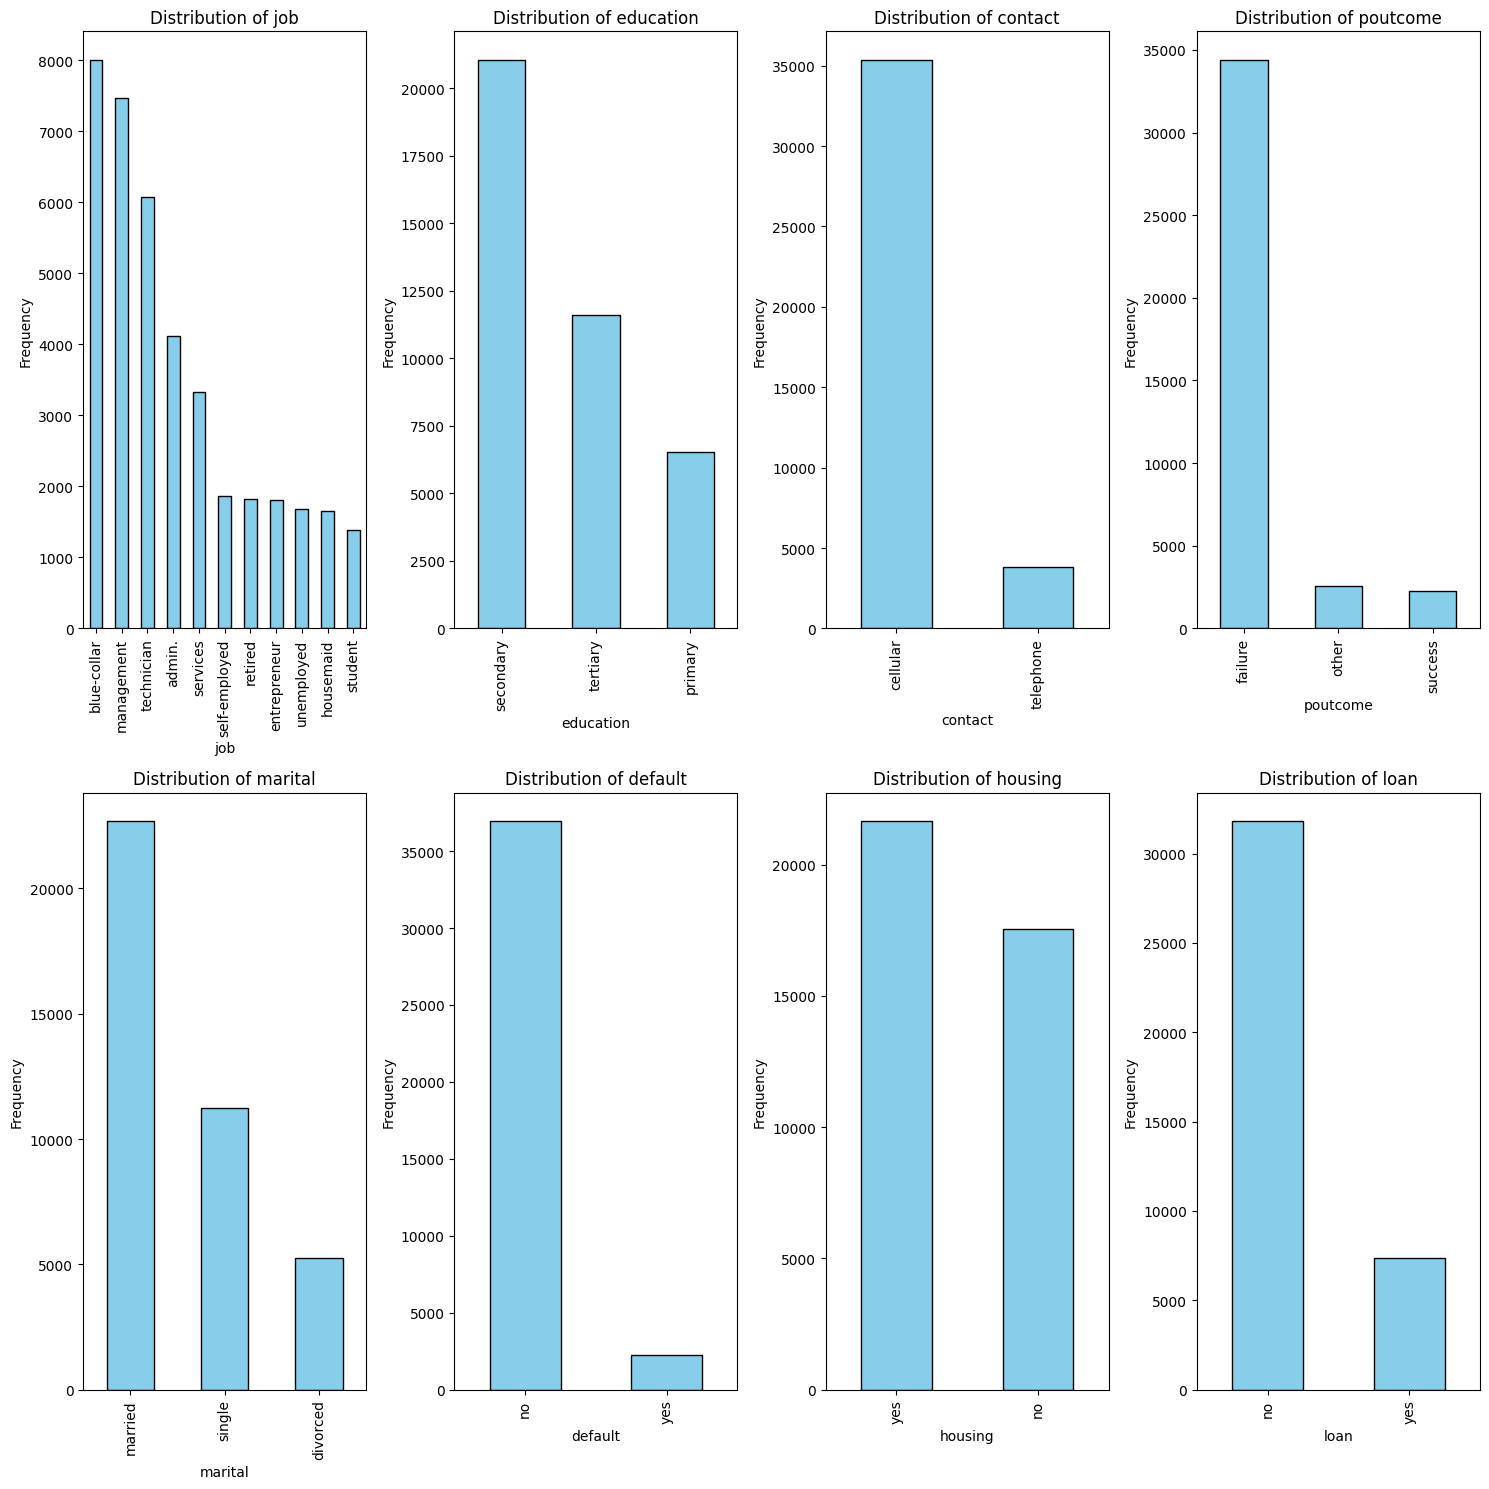

In [19]:
import matplotlib.pyplot as plt

# Create a figure and 3x3 subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 15))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of columns to plot
columns = ['job', 'education', 'contact', 'poutcome', 'marital', 'default', 
           'housing', 'loan']

# Iterate over the columns and plot each one in a separate subplot
for i, col in enumerate(columns):
    X_train[col].value_counts().plot(
        kind='bar',
        ax=axes[i],
        color='skyblue',
        edgecolor='black',
        title=f'Distribution of {col}'
    )
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any remaining empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Distribution of target'}, xlabel='target'>

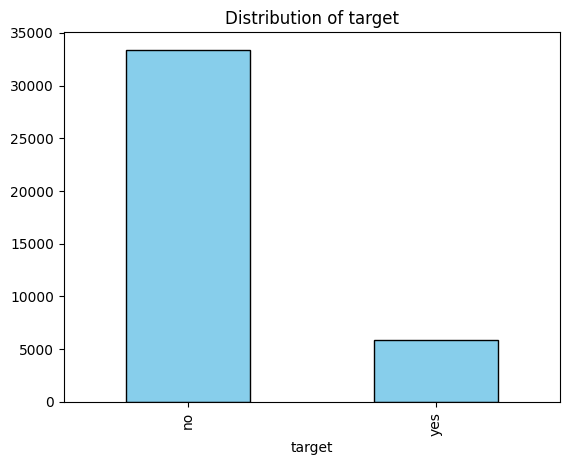

In [20]:
Y_train.value_counts().plot(
        kind='bar',
        color='skyblue',
        edgecolor='black',
        title=f'Distribution of target'
    )

### Pie Charts

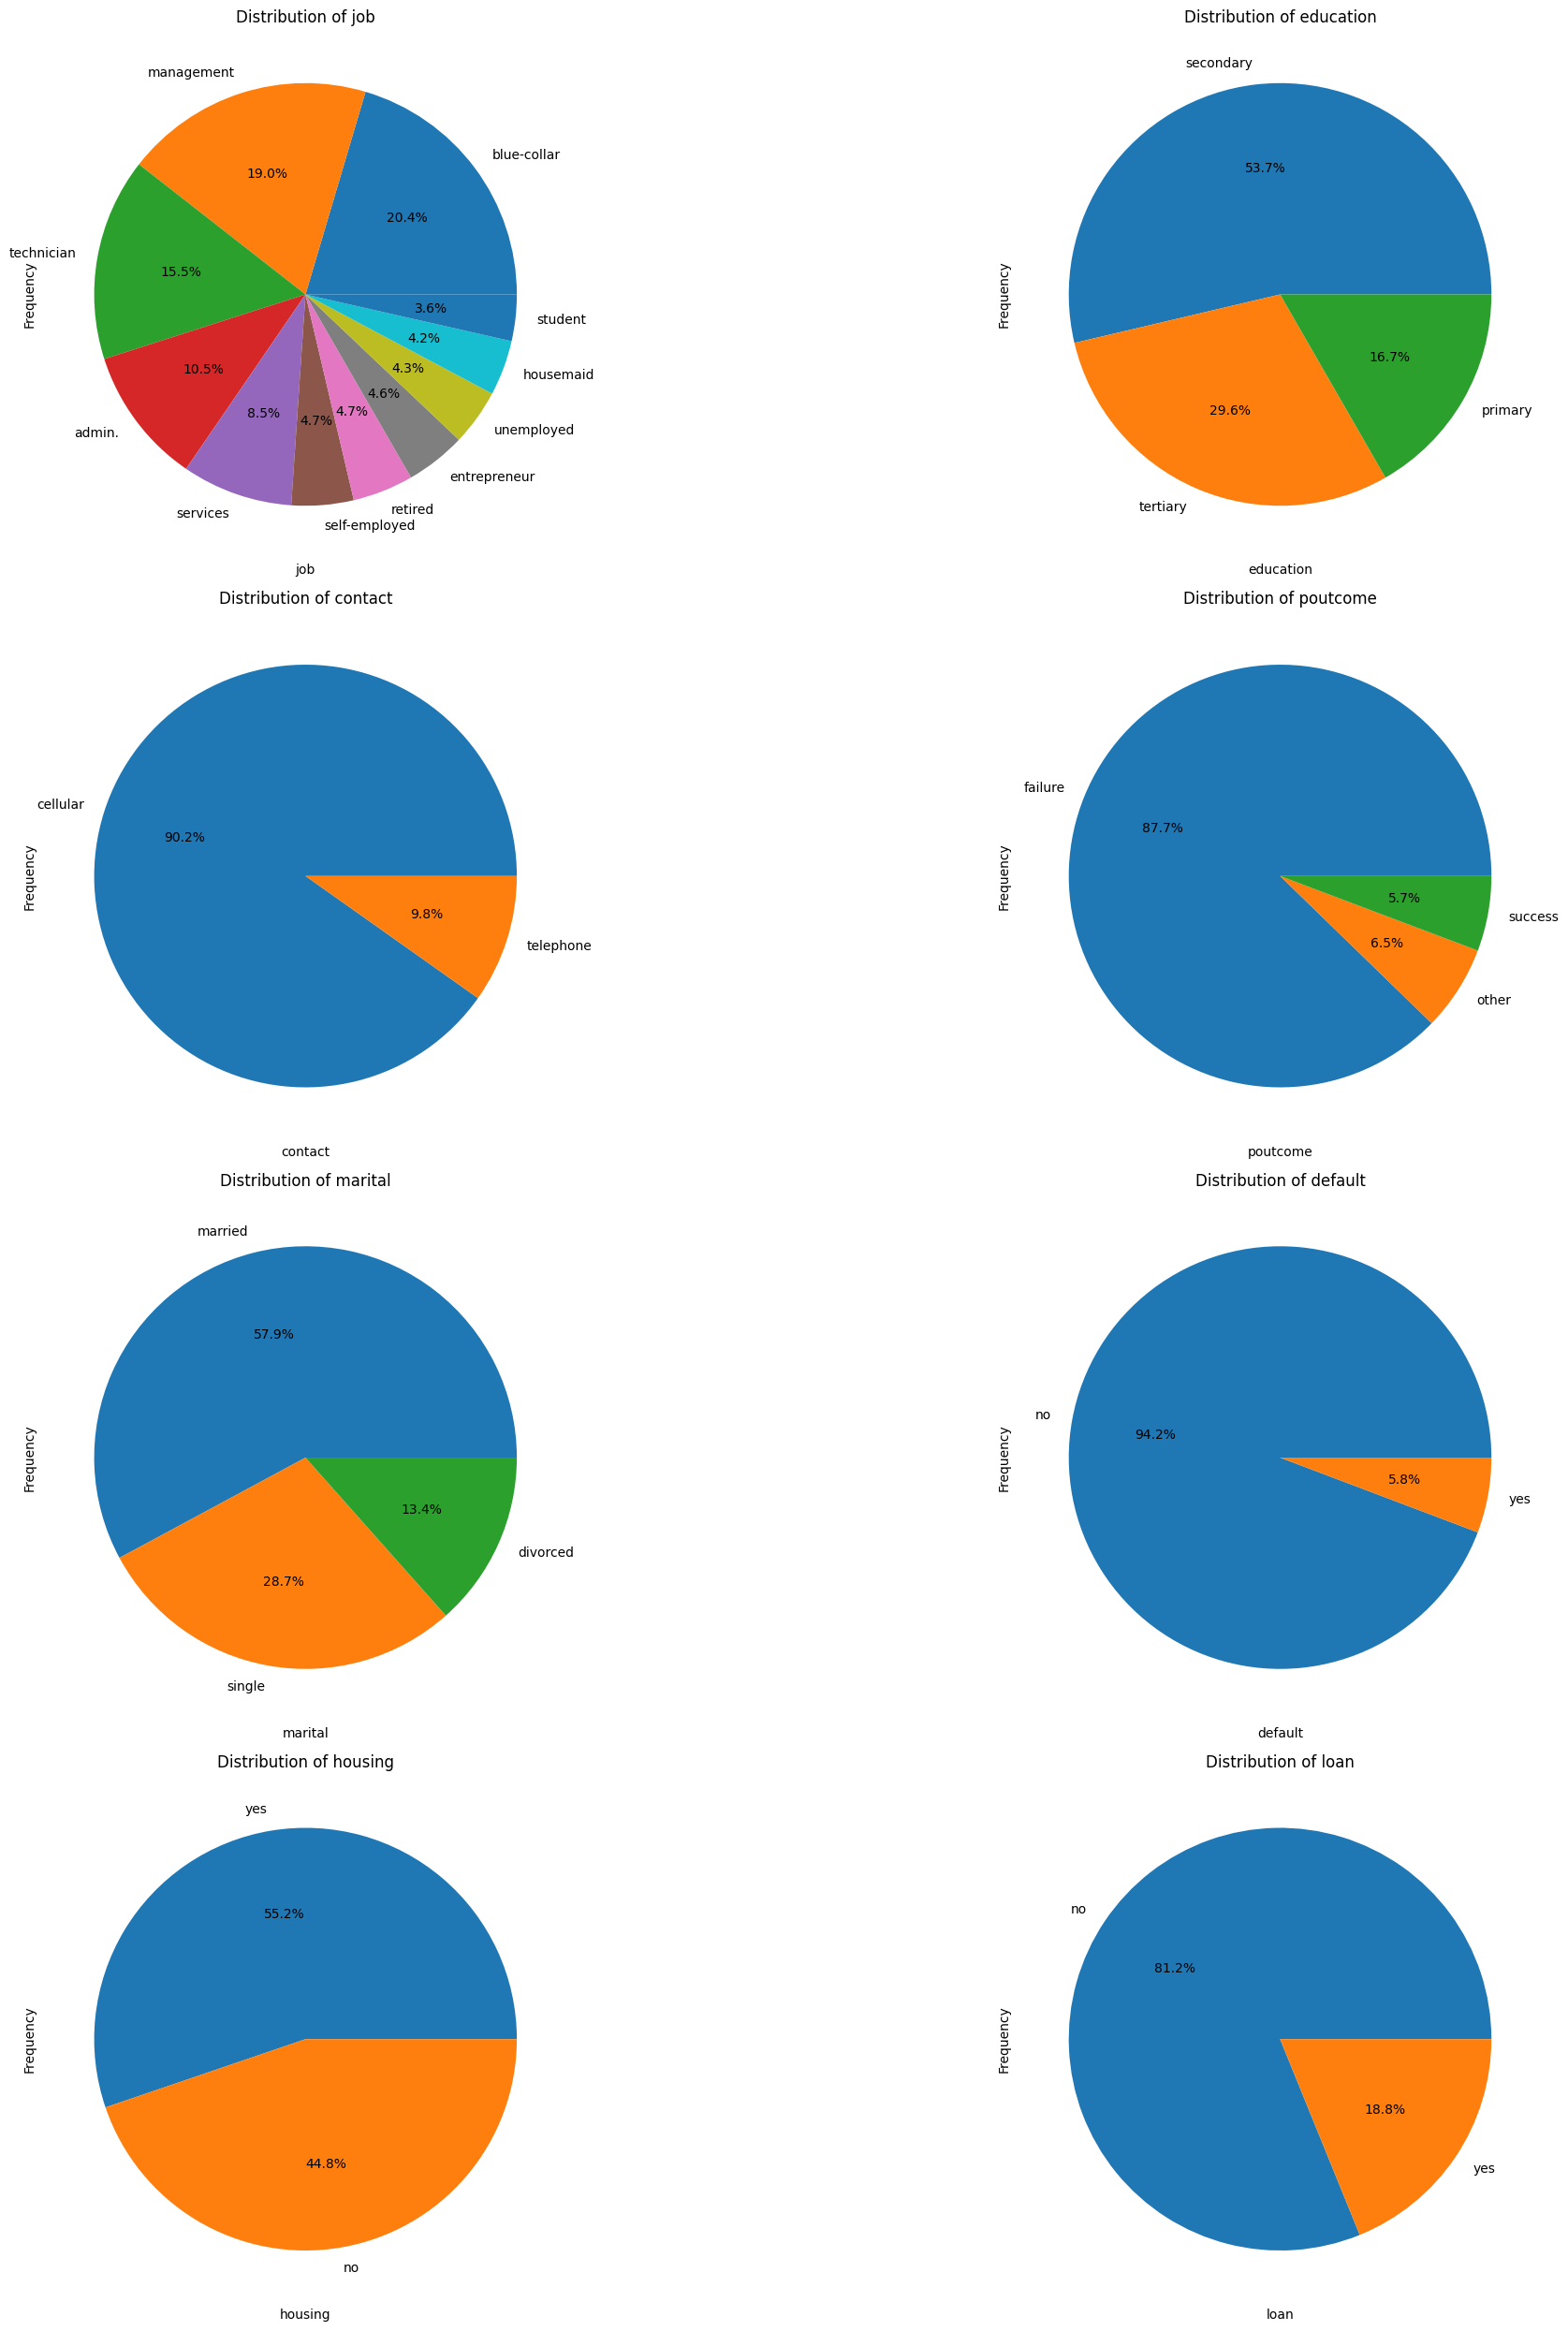

In [21]:
import matplotlib.pyplot as plt

# Create a figure and 3x3 subplots
fig, axes = plt.subplots(4, 2, figsize=(25, 25))  # Adjust figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# List of columns to plot
columns = ['job', 'education', 'contact', 'poutcome', 'marital', 'default', 
           'housing', 'loan']

# Iterate over the columns and plot each one in a separate subplot
for i, col in enumerate(columns):
    X_train[col].value_counts().plot(
        kind='pie',
        ax=axes[i],
        color='skyblue',
        title=f'Distribution of {col}',
        autopct='%1.1f%%'
    )
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    
for ax in axes:
    ax.patch.set_edgecolor('black')  # Set the border color
    ax.patch.set_linewidth(10) 

# Hide any remaining empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Distribution of target'}, ylabel='count'>

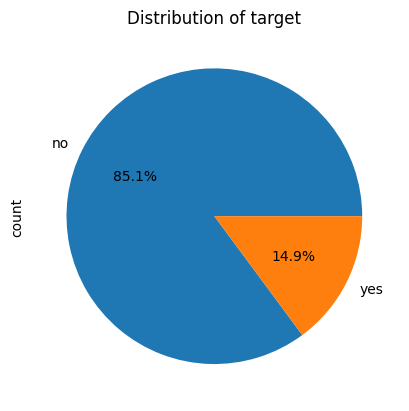

In [22]:
Y_train.value_counts().plot(kind='pie',title=f'Distribution of target',autopct='%1.1f%%')

## Analyzes of Numerical variables

In [23]:
numerical_data=['age','balance','duration','campaign','pdays','previous']

### Histograms

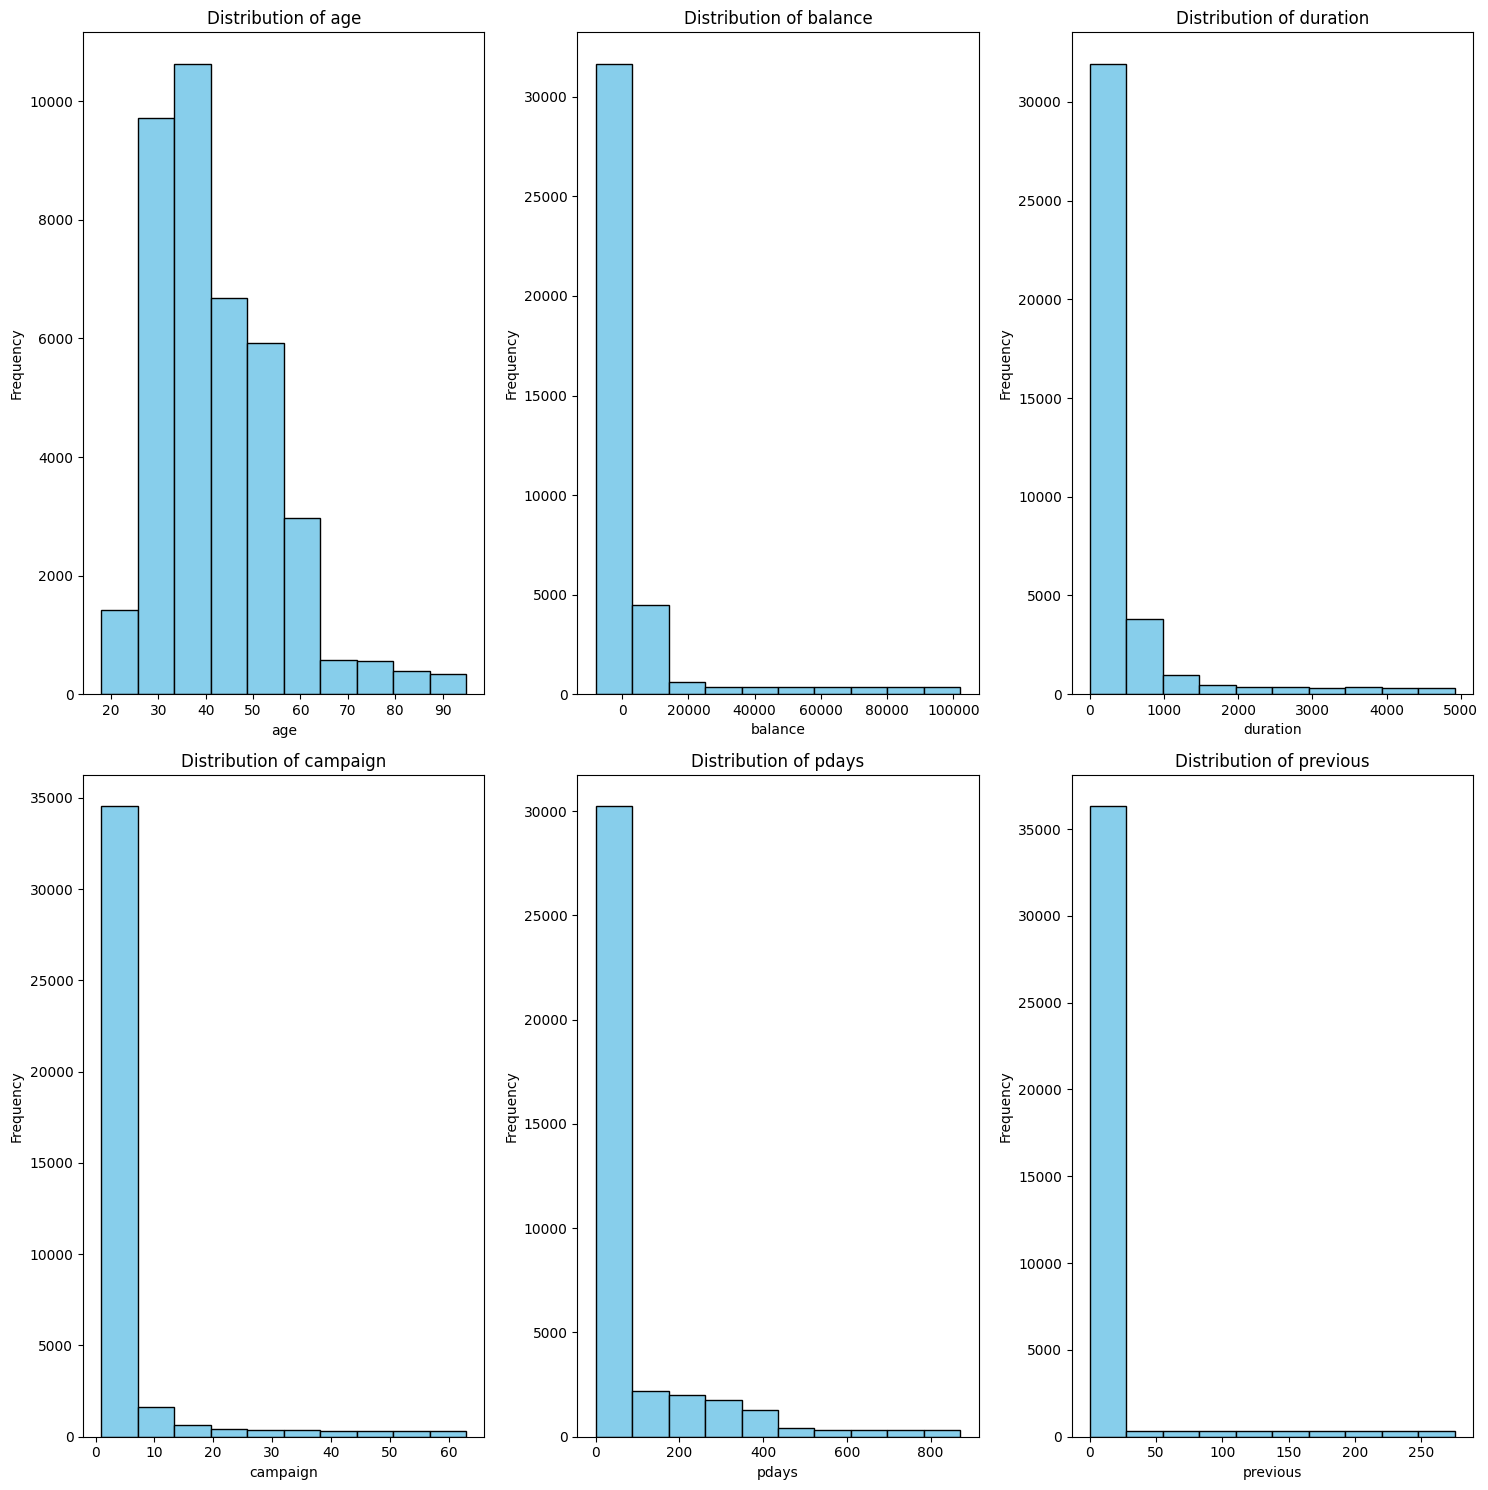

In [24]:
# Create a figure and 2x4 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the columns and plot each one in a separate subplot
for i, col in enumerate(numerical_data):
    # Plot histogram on the respective axis
    X_train[col].plot(
        kind='hist',
        ax=axes[i],
        color='skyblue',
        edgecolor='black',
        title=f'Distribution of {col}',
        bins=10
    )
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any remaining empty subplots
for j in range(len(numerical_data), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [25]:
print(X_train['last contact date'].max())
print(X_train['last contact date'].min())

2010-12-30
2008-01-01


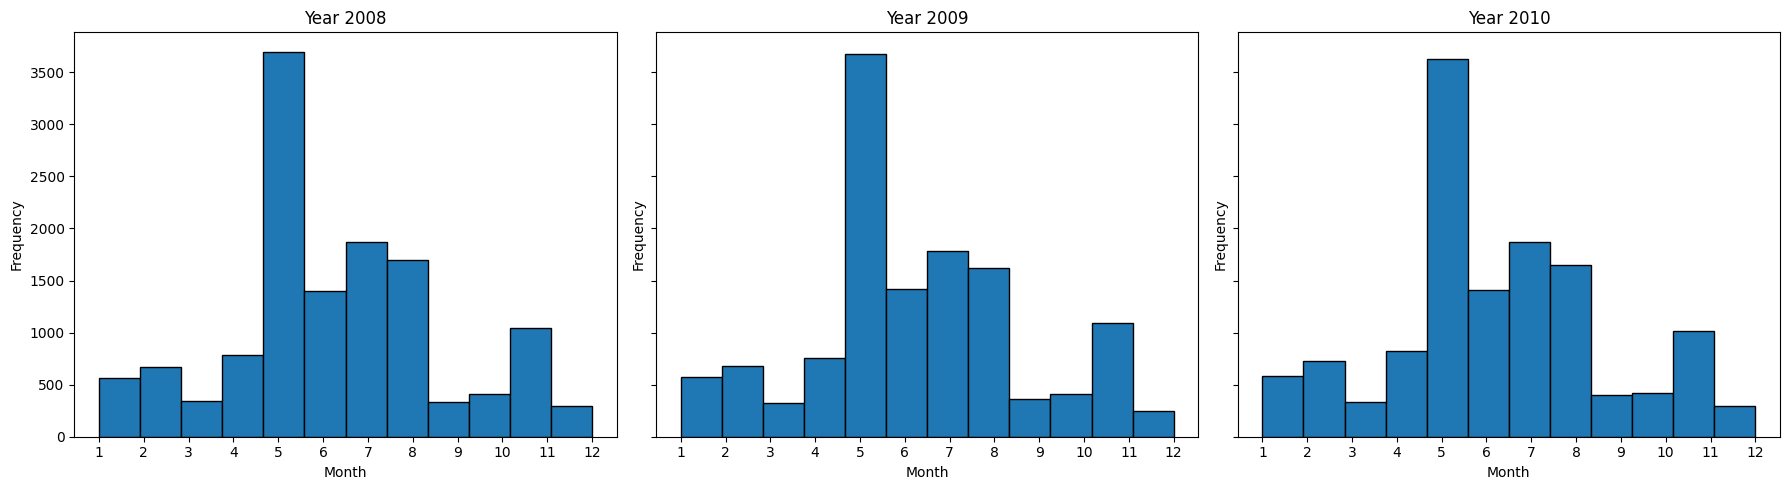

In [26]:
import matplotlib.pyplot as plt

# Extract the year from the 'last contact date' column
X_train['year'] = pd.to_datetime(X_train['last contact date'], errors='coerce').dt.year

# Define the years you want to plot
years = [2008, 2009, 2010]

# Create a figure with 3 subplots, one for each year
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate(years):
    # Filter data for the specific year
    data_for_year = X_train[X_train['year'] == year]
    
    # Plot the histogram for the month of that year
    axes[i].hist(pd.to_datetime(data_for_year['last contact date']).dt.month, bins=12, edgecolor='black')
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Frequency')
    
    # Set x-ticks from 1 to 12 for the months
    axes[i].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()
X_train=X_train.drop(['year'],axis=1)

### Box Plots

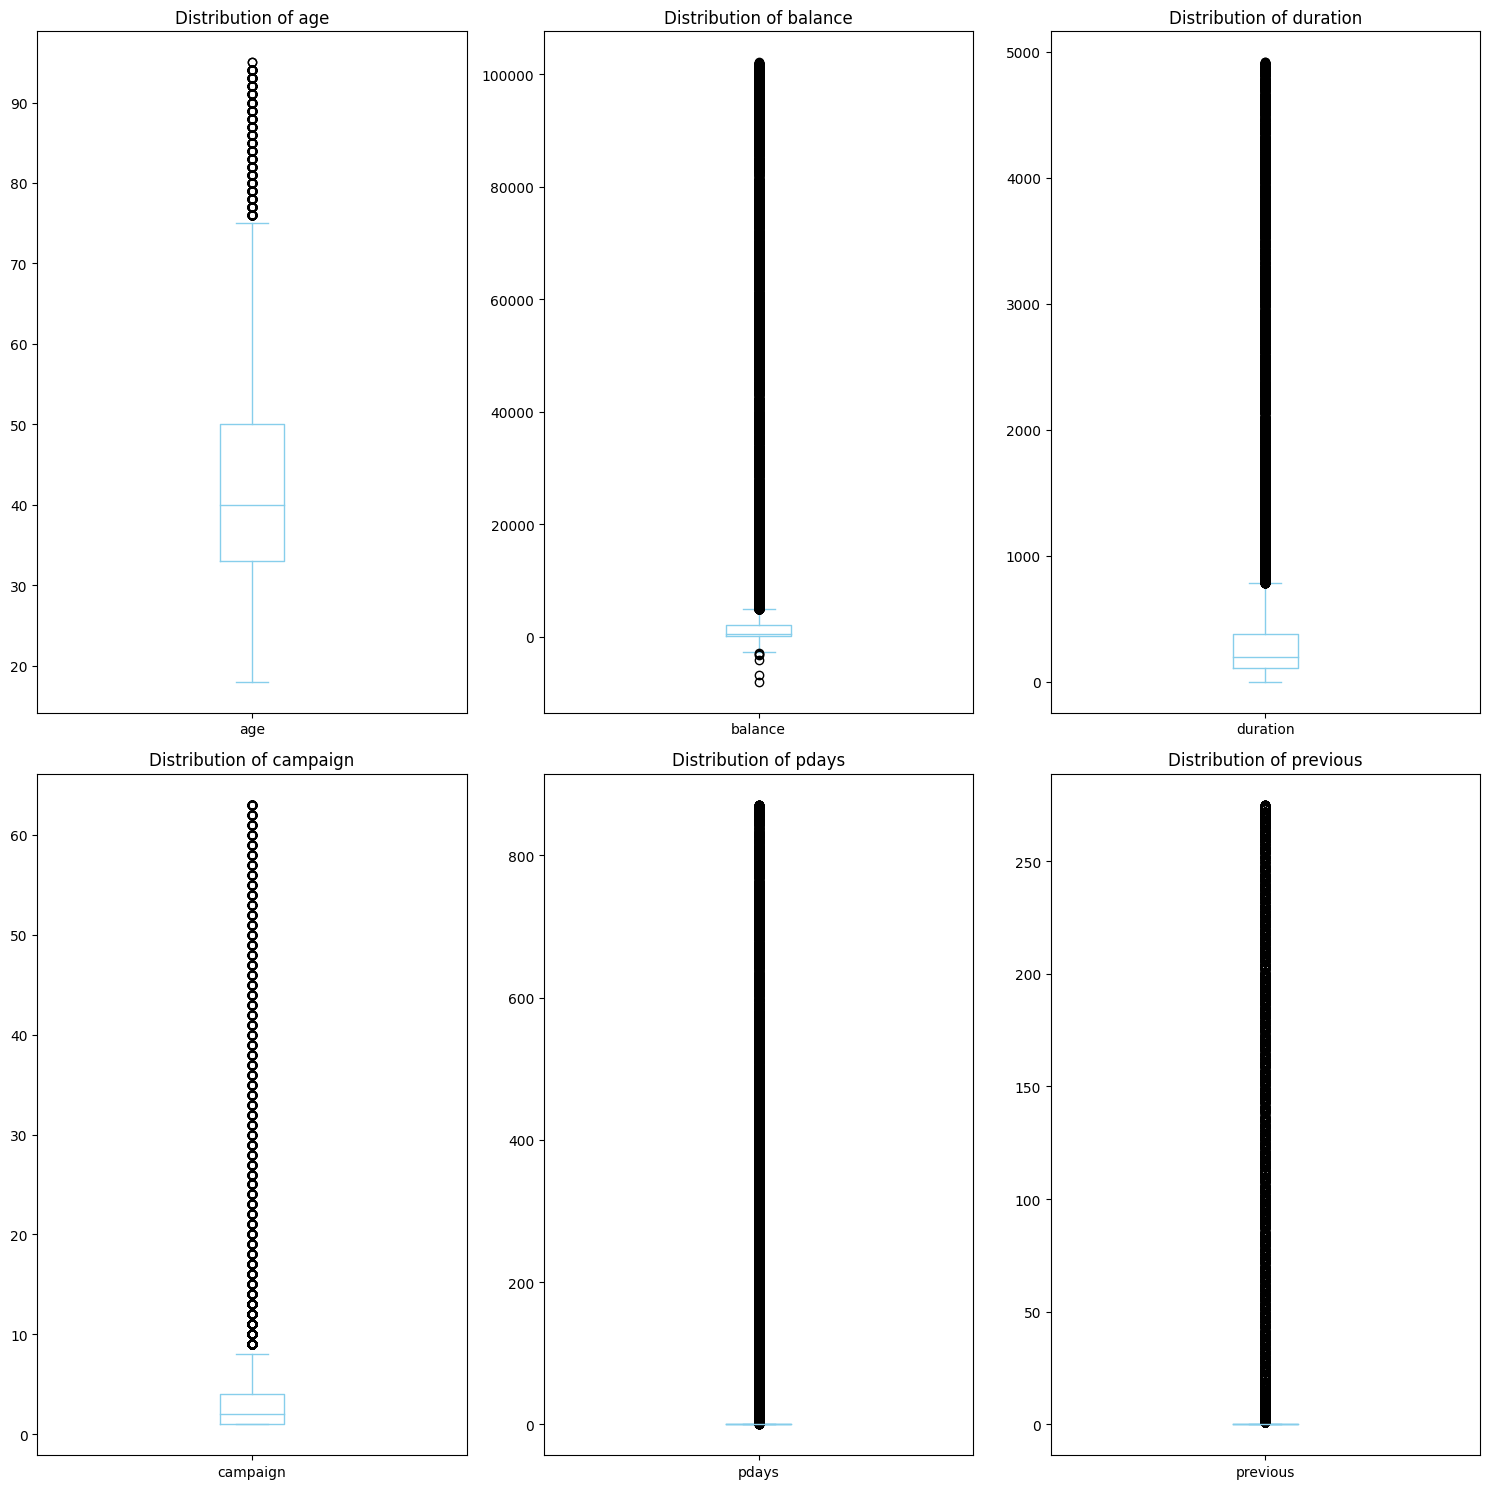

In [27]:
# Create a figure and 2x4 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over the columns and plot each one in a separate subplot
for i, col in enumerate(numerical_data):
    # Plot histogram on the respective axis
    X_train[col].plot(
        kind='box',
        ax=axes[i],
        color='skyblue',
        title=f'Distribution of {col}',
    )

# Hide any remaining empty subplots
for j in range(len(numerical_data), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [28]:
X_train[numerical_data]=X_train[numerical_data].astype('int64')

In [29]:
X_train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,73.007013,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.600988,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,0.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,0.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,0.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,0.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


## Bivariate Analysis

### Scatter Plots

In [30]:
# import warnings
# warnings.filterwarnings('ignore',category=FutureWarning)
# import seaborn as sns
# import matplotlib.pyplot as plt
# for i in categorical_data:
#     # Combine the categorical and numerical data
#     data_subset = pd.concat([X_train[i], X_train[numerical_data]], axis=1)
    
#     # Sample 1000 random points
#     data_sampled = data_subset.sample(n=1000, random_state=42)  # Set random_state for reproducibility
    
#     # Create pairplot using seaborn with the categorical variable as the hue
#     sns.pairplot(data_sampled, hue=i, diag_kind='kde')
#     plt.show()

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Step 1: Convert the 'date_column' to datetime
X_train['last contact date'] = pd.to_datetime(X_train['last contact date'])

# Step 2: Split the datetime column into day, month, and year
X_train['day'] = X_train['last contact date'].dt.day
X_train['month'] = X_train['last contact date'].dt.month
X_train['year'] = X_train['last contact date'].dt.year

# # # Step 3: Drop the 'year' column
# # X_train = X_train.drop('year', axis=1)

# Step 4: Scale the day and month columns
scaler = StandardScaler()
X_train[['day', 'month', 'year']] = scaler.fit_transform(X_train[['day', 'month','year']])

# print(X_train)

In [32]:
X_train[['day', 'month', 'year']]

,day,month,year
0,0.144707,-0.850723,-0.000966
1,-0.573323,1.444400,-0.000966
2,0.503722,1.826920,1.220924
3,-1.770039,1.061879,-0.000966
4,1.580767,-1.998284,-1.222856
...,...,...,...
39206,1.820110,0.296838,-1.222856
39207,1.820110,0.296838,-0.000966
39208,-1.650368,-0.085682,-1.222856
39209,0.503722,-1.233243,1.220924


### Correlation Matrix

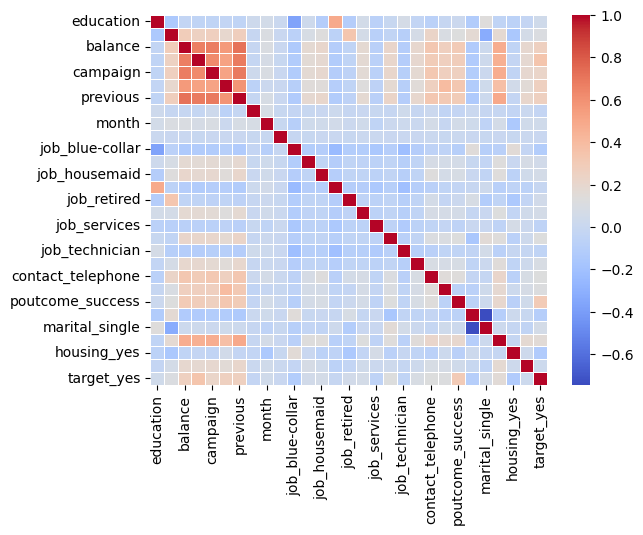

In [33]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
Encoded_education=pd.DataFrame(LabelEncoder().fit_transform(X_train['education']), columns=['education'])

encoded_data=pd.get_dummies(pd.concat([Encoded_education,X_train.drop(['last contact date','education'],
                                                                  axis=1),Y_train],axis=1),
                            drop_first=True)
sns.heatmap(encoded_data.corr(),cmap='coolwarm', linewidth=0.5, annot=False)
sns.set(font_scale=0.7)
plt.show()

In [34]:
encoded_data[['day', 'month', 'year']]

,day,month,year
0,0.144707,-0.850723,-0.000966
1,-0.573323,1.444400,-0.000966
2,0.503722,1.826920,1.220924
3,-1.770039,1.061879,-0.000966
4,1.580767,-1.998284,-1.222856
...,...,...,...
39206,1.820110,0.296838,-1.222856
39207,1.820110,0.296838,-0.000966
39208,-1.650368,-0.085682,-1.222856
39209,0.503722,-1.233243,1.220924


In [35]:
X_train

,job,education,contact,poutcome,last contact date,age,marital,default,balance,housing,loan,duration,campaign,pdays,previous,day,month,year
0,blue-collar,secondary,cellular,other,2009-04-17,26,married,no,647,yes,no,357,2,331,1,0.144707,-0.850723,-0.000966
1,technician,secondary,telephone,failure,2009-10-11,52,married,no,553,yes,no,160,1,0,0,-0.573323,1.444400,-0.000966
2,blue-collar,secondary,cellular,failure,2010-11-20,44,married,no,1397,no,no,326,1,0,0,0.503722,1.826920,1.220924
3,admin.,secondary,telephone,failure,2009-09-01,33,married,no,394,yes,no,104,3,0,0,-1.770039,1.061879,-0.000966
4,entrepreneur,tertiary,cellular,failure,2008-01-29,31,single,no,137,no,no,445,2,0,0,1.580767,-1.998284,-1.222856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,technician,secondary,cellular,failure,2008-07-31,31,single,no,0,yes,no,16,34,0,0,1.820110,0.296838,-1.222856
39207,admin.,primary,cellular,failure,2009-07-31,59,married,no,6187,no,no,114,4,0,0,1.820110,0.296838,-0.000966
39208,blue-collar,secondary,cellular,failure,2008-06-02,36,married,no,63,yes,no,56,8,0,0,-1.650368,-0.085682,-1.222856
39209,student,secondary,cellular,failure,2010-03-20,28,single,no,5916,no,no,93,5,0,0,0.503722,-1.233243,1.220924


In [36]:
pd.DataFrame(Y_train).shape

(39211, 1)

## Identifying Trends

### Line Graph

In [37]:
import pandas as pd

# Assuming 'last contact date' is already in datetime format
X_train['last contact date'] = pd.to_datetime(X_train['last contact date'])

# Extract the year and month
X_train['Year'] = X_train['last contact date'].dt.year
X_train['Month'] = X_train['last contact date'].dt.month

# Group by year and month, and calculate the mean for each numerical column
df_grouped = X_train.groupby(['Year', 'Month'])[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].mean().reset_index()

# Display the grouped data
print(df_grouped)


    Year  Month        age       balance     duration   campaign       pdays  \
0   2008      1  44.798942  18034.479718  1103.199295  12.317460  190.058201   
1   2008      2  40.851412   1368.050520   252.858841   2.454681   67.077266   
2   2008      3  49.849711  32094.416185  1712.222543  20.523121  267.563584   
3   2008      4  39.778344   1590.708280   293.461146   1.961783   92.151592   
4   2008      5  39.041633   1016.871317   264.562314   2.476615   54.473642   
5   2008      6  42.395299   1667.926638   247.782764   3.189459   11.372507   
6   2008      7  40.906267    800.463846   271.875201   3.401178    8.639529   
7   2008      8  42.936283   1381.604130   230.978171   3.978171   14.910324   
8   2008      9  50.021148  28695.845921  1547.220544  18.839879  290.123867   
9   2008     10  50.936118  30423.963145  1542.196560  18.189189  286.611794   
10  2008     11  41.579502   2615.267241   251.906130   1.878352   43.866858   
11  2008     12  54.822148  44217.238255

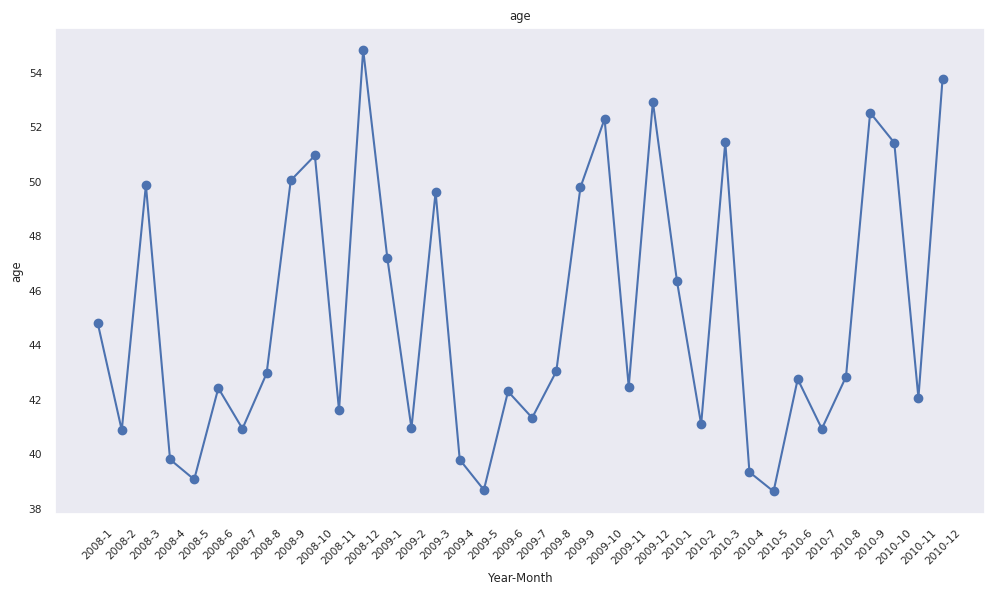

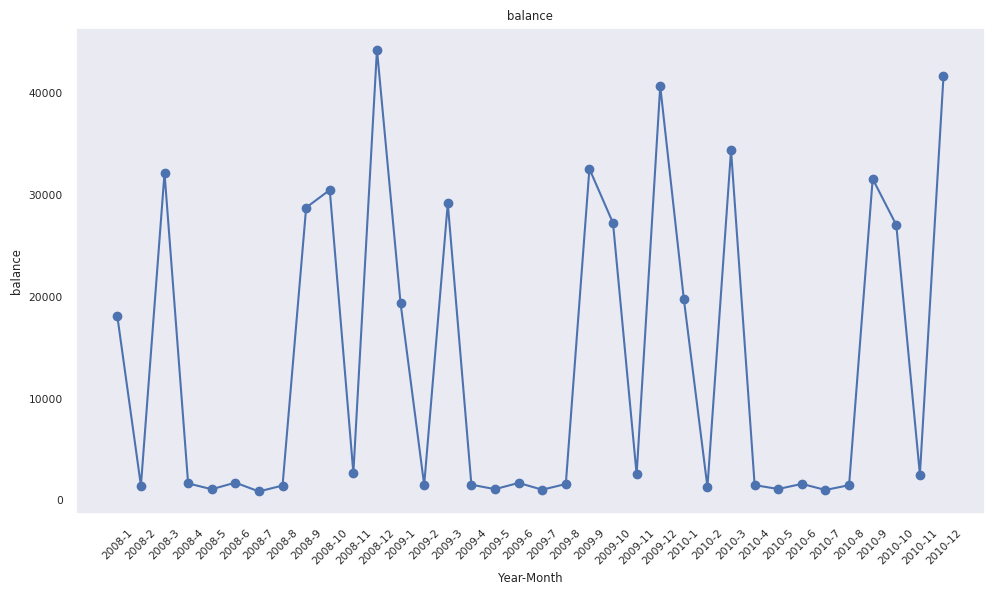

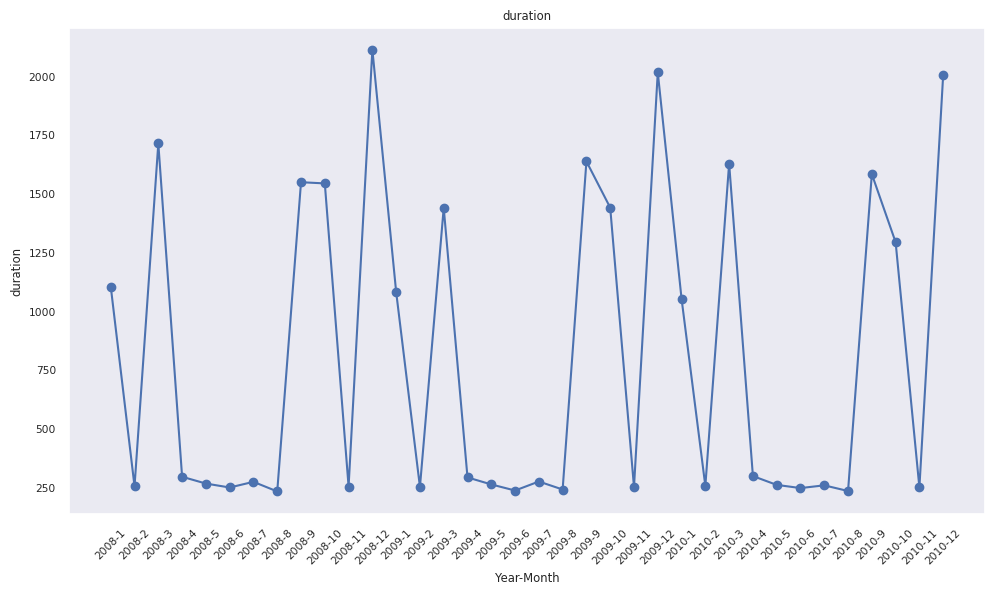

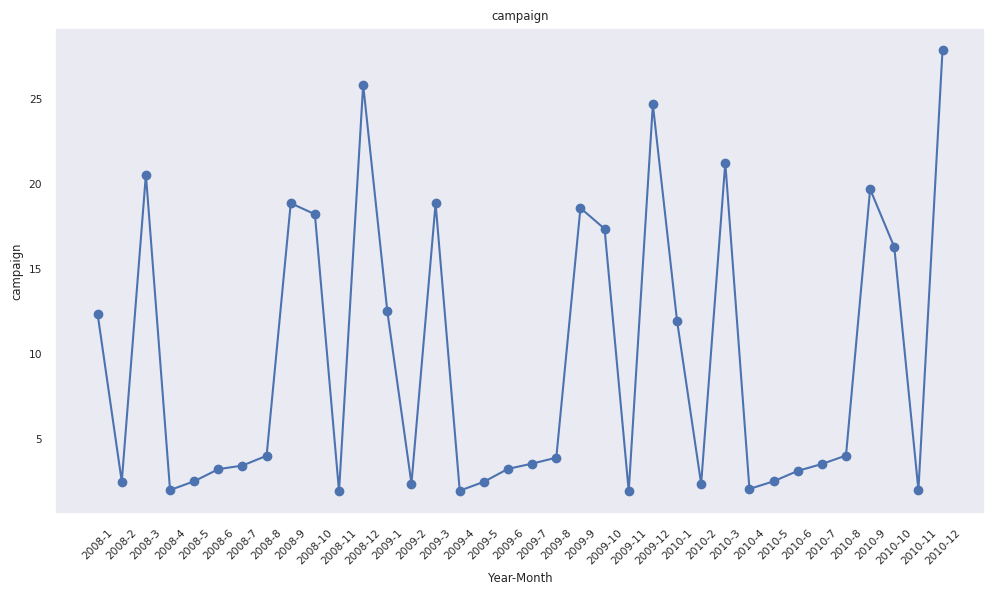

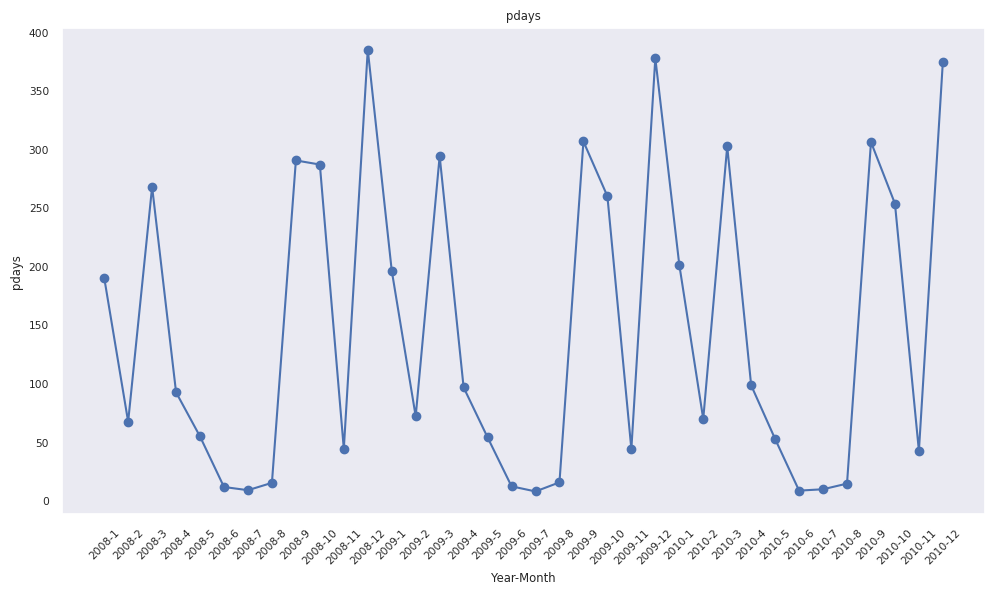

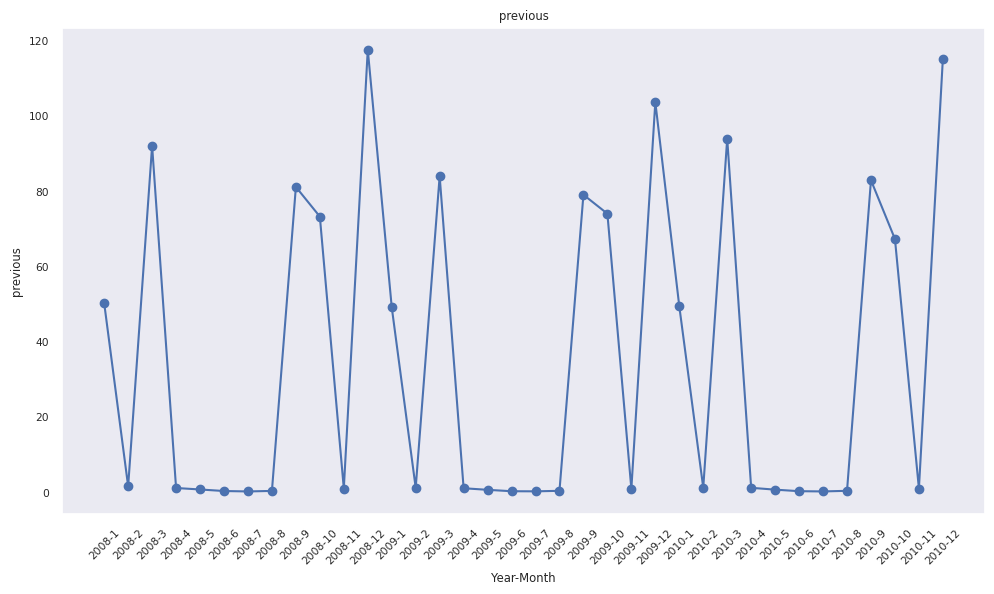

In [38]:
for i in ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']:
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plotting the line graph for each numerical column
    plt.plot(df_grouped['Year'].astype(str) + '-' + df_grouped['Month'].astype(str), df_grouped[i], marker='o')

    plt.title(i)  # Set the title
    plt.xlabel('Year-Month')  # Set the x-axis label
    plt.ylabel(i)  # Set the y-axis label

    plt.grid()  # Add gridlines
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout for better spacing

    plt.show()  # Display the graph

#### Bifurcation by value of target variable 'yes' and 'no'

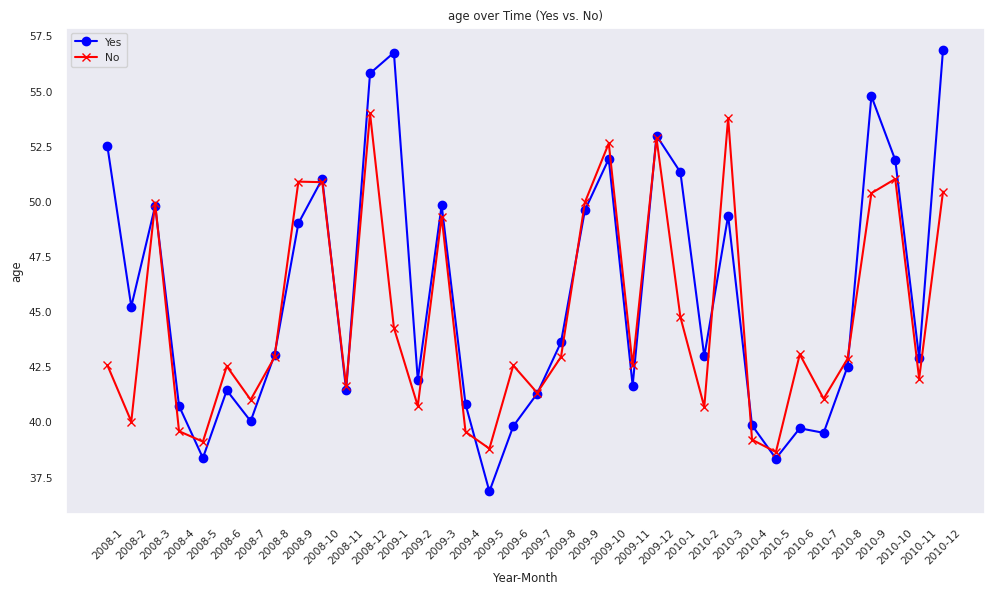

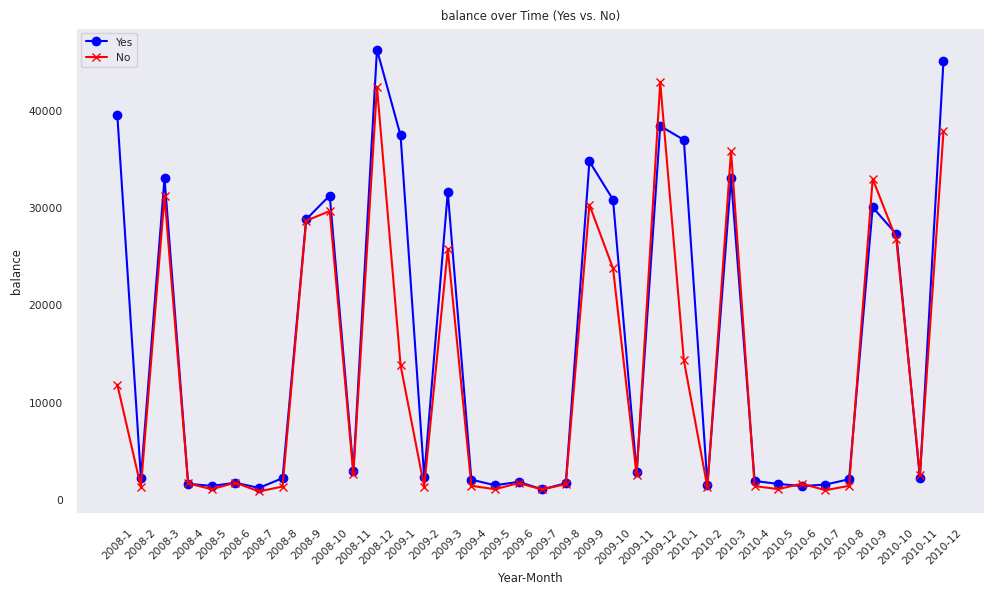

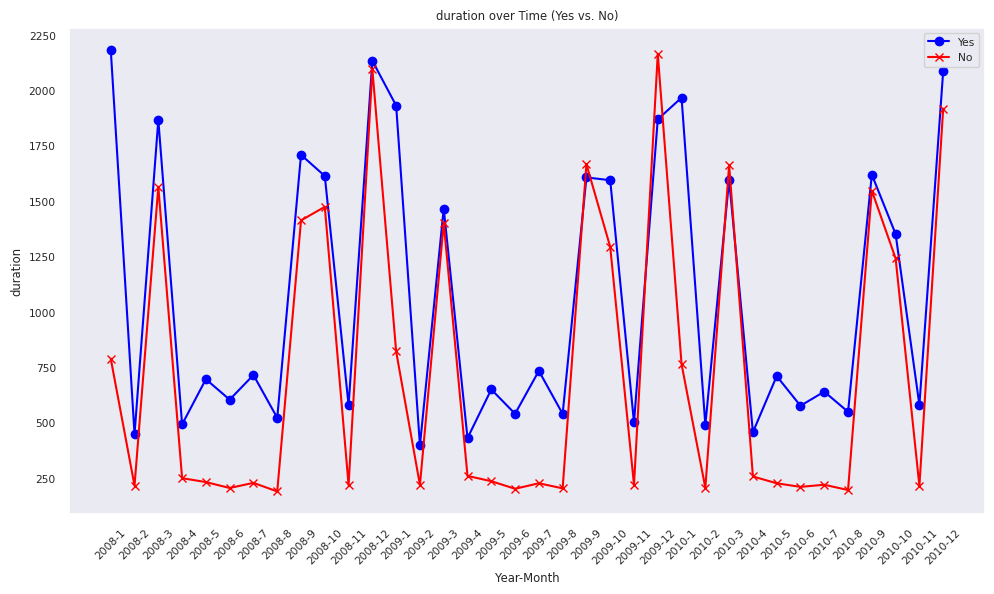

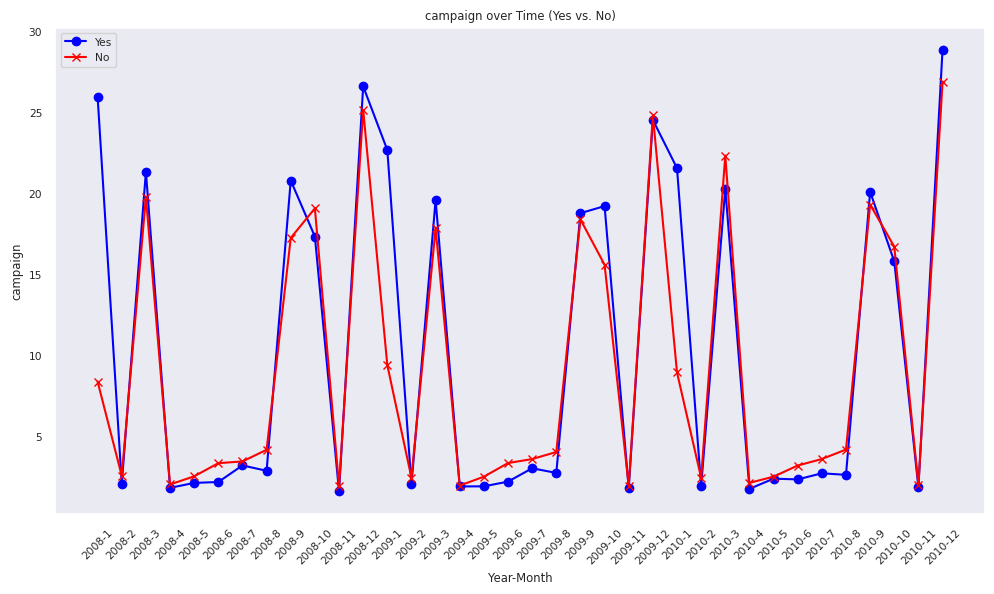

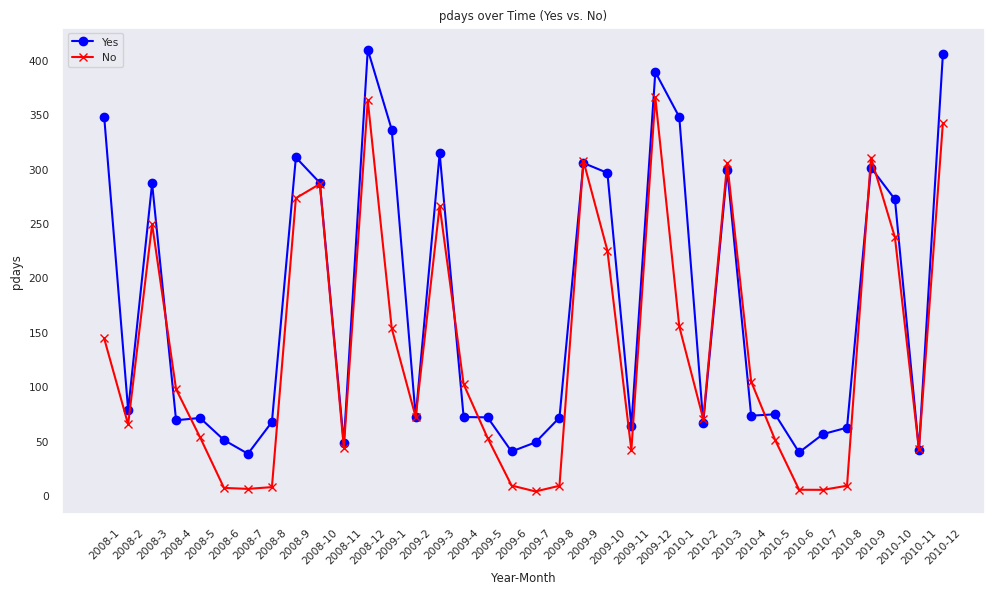

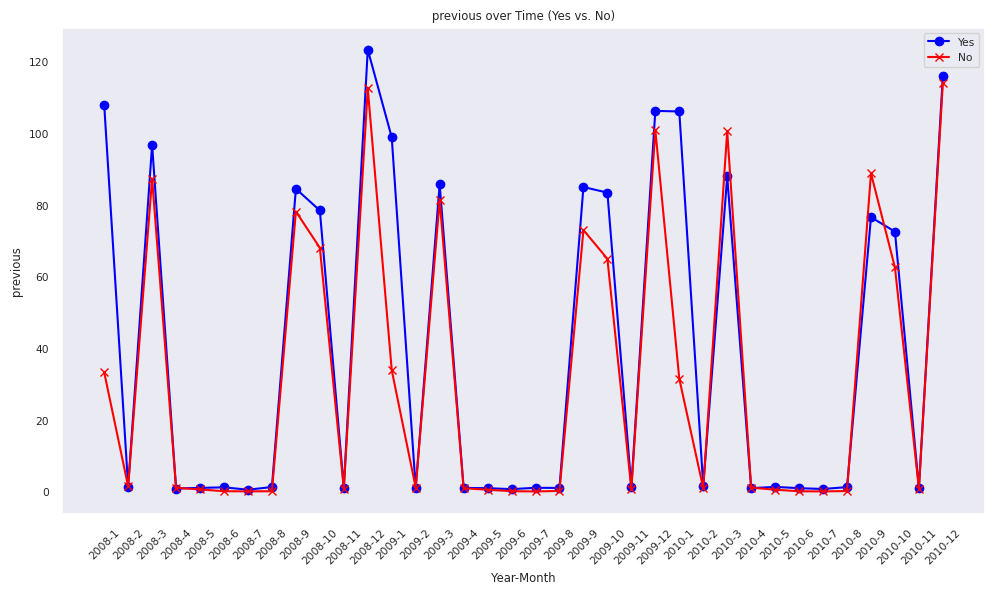

In [39]:
import matplotlib.pyplot as plt

# Separate the data into Yes_data and No_data
Yes_data = X_train[data['target'] == 'yes']
No_data = X_train[data['target'] == 'no']

# Ensure 'last contact date' is in datetime format
Yes_data['last contact date'] = pd.to_datetime(Yes_data['last contact date'])
No_data['last contact date'] = pd.to_datetime(No_data['last contact date'])

# Extract Year and Month
Yes_data['Year'] = Yes_data['last contact date'].dt.year
Yes_data['Month'] = Yes_data['last contact date'].dt.month
No_data['Year'] = No_data['last contact date'].dt.year
No_data['Month'] = No_data['last contact date'].dt.month

# Group by year and month, calculating the mean for each group
Yes_grouped = Yes_data.groupby(['Year', 'Month'])[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].mean().reset_index()
No_grouped = No_data.groupby(['Year', 'Month'])[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']].mean().reset_index()

# Plotting the graphs
for i in ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']:
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Plot line for Yes_data
    plt.plot(Yes_grouped['Year'].astype(str) + '-' + Yes_grouped['Month'].astype(str), 
             Yes_grouped[i], marker='o', label='Yes', color='blue')

    # Plot line for No_data
    plt.plot(No_grouped['Year'].astype(str) + '-' + No_grouped['Month'].astype(str), 
             No_grouped[i], marker='x', label='No', color='red')

    # Add title and labels
    plt.title(f'{i} over Time (Yes vs. No)')
    plt.xlabel('Year-Month')
    plt.ylabel(i)

    # Add gridlines and rotate x-axis labels
    plt.grid()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add legend
    plt.legend()

    # Display the graph
    plt.show()

# Baseline Model

In [40]:
# from sklearn.dummy import DummyClassifier
# model = DummyClassifier().fit(X_train,Y_train)

# y_pred=model.predict(test_data)

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

In [41]:
a=encoded_data.columns
len(a)

29

# Building a function for model evaluation

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

def evaluate_model(model, X_val, y_val):
    # Get model predictions
    y_pred = model.predict(X_val)
    
    # Check if model has predict_proba attribute
    has_proba = hasattr(model, "predict_proba")
    y_prob = model.predict_proba(X_val)[:, 1] if has_proba else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, pos_label='yes')
    recall = recall_score(y_val, y_pred, pos_label='yes')
    f1 = f1_score(y_val, y_pred, pos_label='yes')
    auc = roc_auc_score(y_val, y_prob) if has_proba else None
    
    # Classification report and confusion matrix
    report = classification_report(y_val, y_pred, target_names=['no', 'yes'])
    confusion = confusion_matrix(y_val, y_pred)
    
    # Display metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if auc is not None:
        print("AUC Score:", auc)
    print("\nClassification Report:\n", report)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot ROC curve if predict_proba is available
    if has_proba:
        fpr, tpr, thresholds = roc_curve(y_val, y_prob, pos_label='yes')
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

# Further processing test data

In [43]:
encoded_data.columns

Index(['education', 'age', 'balance', 'duration', 'campaign', 'pdays',
       'previous', 'day', 'month', 'year', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'contact_telephone', 'poutcome_other',
       'poutcome_success', 'marital_married', 'marital_single', 'default_yes',
       'housing_yes', 'loan_yes', 'target_yes'],
      dtype='object')

In [44]:
prepro = ColumnTransformer(
    transformers=[
        ('education','passthrough',['education']),
        ('num', StandardScaler(), numerical_data),
    ],
    remainder='passthrough'  
)
s_encoded_data=pd.DataFrame(prepro.fit_transform(encoded_data.drop('target_yes',axis=1)), 
                            columns=[['education', 'age', 'balance', 'duration', 'campaign', 'pdays',
       'previous', 'day', 'month', 'year', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'contact_telephone', 'poutcome_other',
       'poutcome_success', 'marital_married', 'marital_single', 'default_yes',
       'housing_yes', 'loan_yes']])

In [45]:
s_encoded_data.head

<bound method NDFrame.head of       education       age   balance  duration  campaign     pdays  previous  \
0             1 -1.268393 -0.292989 -0.106702 -0.314334  1.606443 -0.245271   
1             1  0.777371 -0.298732  -0.36285 -0.415446 -0.454592 -0.267926   
2             1  0.147905 -0.247159 -0.147009 -0.415446 -0.454592 -0.267926   
3             1  -0.71761 -0.308448 -0.435663 -0.213222 -0.454592 -0.267926   
4             2 -0.874977 -0.324152   0.00772 -0.314334 -0.454592 -0.267926   
...         ...       ...       ...       ...       ...       ...       ...   
39206         1 -0.874977 -0.332524 -0.550085  2.921249 -0.454592 -0.267926   
39207         0  1.328153  0.045537 -0.422661  -0.11211 -0.454592 -0.267926   
39208         1 -0.481561 -0.328674 -0.498075  0.292338 -0.454592 -0.267926   
39209         1 -1.111027  0.028977 -0.449966 -0.010998 -0.454592 -0.267926   
39210         2  0.698688   2.02579  1.869669  1.404569  4.402227  3.085065   

            day     m

In [46]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   job                10000 non-null  object
 1   education          10000 non-null  object
 2   contact            10000 non-null  object
 3   poutcome           10000 non-null  object
 4   last contact date  10000 non-null  object
 5   age                10000 non-null  object
 6   marital            10000 non-null  object
 7   default            10000 non-null  object
 8   balance            10000 non-null  object
 9   housing            10000 non-null  object
 10  loan               10000 non-null  object
 11  duration           10000 non-null  object
 12  campaign           10000 non-null  object
 13  pdays              10000 non-null  object
 14  previous           10000 non-null  object
dtypes: object(15)
memory usage: 1.1+ MB


In [47]:
test_data.columns

Index(['job', 'education', 'contact', 'poutcome', 'last contact date', 'age',
       'marital', 'default', 'balance', 'housing', 'loan', 'duration',
       'campaign', 'pdays', 'previous'],
      dtype='object')

In [48]:
test_data['last contact date'] = pd.to_datetime(test_data['last contact date'])

# Split the datetime column into day, month, and year
test_data['day'] = test_data['last contact date'].dt.day
test_data['month'] = test_data['last contact date'].dt.month
test_data['year'] = test_data['last contact date'].dt.year

# Scale the day and month columns
scaler = StandardScaler()
test_data[['day', 'month', 'year']] = scaler.fit_transform(test_data[['day', 'month','year']])

In [49]:
test_data[numerical_data]=test_data[numerical_data].astype('int64')

Encoded_education_test=pd.DataFrame(LabelEncoder().fit_transform(test_data['education']), 
                                    columns=['education'])

encoded_data_test=pd.get_dummies(pd.concat([Encoded_education_test,
                                            test_data.drop(['last contact date','education'], 
                                                           axis=1)],axis=1), drop_first=True)

prepro_test = ColumnTransformer(
    transformers=[
        ('education','passthrough',['education']),
        ('num', StandardScaler(), numerical_data),
    ],
    remainder='passthrough'  
)
s_encoded_data_test=pd.DataFrame(prepro.fit_transform(encoded_data_test), 
                            columns=[encoded_data_test.columns])

In [50]:
s_encoded_data.head

<bound method NDFrame.head of       education       age   balance  duration  campaign     pdays  previous  \
0             1 -1.268393 -0.292989 -0.106702 -0.314334  1.606443 -0.245271   
1             1  0.777371 -0.298732  -0.36285 -0.415446 -0.454592 -0.267926   
2             1  0.147905 -0.247159 -0.147009 -0.415446 -0.454592 -0.267926   
3             1  -0.71761 -0.308448 -0.435663 -0.213222 -0.454592 -0.267926   
4             2 -0.874977 -0.324152   0.00772 -0.314334 -0.454592 -0.267926   
...         ...       ...       ...       ...       ...       ...       ...   
39206         1 -0.874977 -0.332524 -0.550085  2.921249 -0.454592 -0.267926   
39207         0  1.328153  0.045537 -0.422661  -0.11211 -0.454592 -0.267926   
39208         1 -0.481561 -0.328674 -0.498075  0.292338 -0.454592 -0.267926   
39209         1 -1.111027  0.028977 -0.449966 -0.010998 -0.454592 -0.267926   
39210         2  0.698688   2.02579  1.869669  1.404569  4.402227  3.085065   

            day     m

In [51]:
s_encoded_data_test.columns

MultiIndex([(        'education',),
            (              'age',),
            (          'balance',),
            (         'duration',),
            (         'campaign',),
            (            'pdays',),
            (         'previous',),
            (              'day',),
            (            'month',),
            (             'year',),
            (  'job_blue-collar',),
            ( 'job_entrepreneur',),
            (    'job_housemaid',),
            (   'job_management',),
            (      'job_retired',),
            ('job_self-employed',),
            (     'job_services',),
            (      'job_student',),
            (   'job_technician',),
            (   'job_unemployed',),
            ('contact_telephone',),
            (   'poutcome_other',),
            ( 'poutcome_success',),
            (  'marital_married',),
            (   'marital_single',),
            (      'default_yes',),
            (      'housing_yes',),
            (         'loan_

In [52]:
s_encoded_data.columns==s_encoded_data_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [53]:
s_encoded_data.head()

,education,age,balance,duration,campaign,pdays,previous,day,month,year,...,job_technician,job_unemployed,contact_telephone,poutcome_other,poutcome_success,marital_married,marital_single,default_yes,housing_yes,loan_yes
0,1,-1.268393,-0.292989,-0.106702,-0.314334,1.606443,-0.245271,0.144707,-0.850723,-0.000966,...,False,False,False,True,False,True,False,False,True,False
1,1,0.777371,-0.298732,-0.36285,-0.415446,-0.454592,-0.267926,-0.573323,1.4444,-0.000966,...,True,False,True,False,False,True,False,False,True,False
2,1,0.147905,-0.247159,-0.147009,-0.415446,-0.454592,-0.267926,0.503722,1.82692,1.220924,...,False,False,False,False,False,True,False,False,False,False
3,1,-0.71761,-0.308448,-0.435663,-0.213222,-0.454592,-0.267926,-1.770039,1.061879,-0.000966,...,False,False,True,False,False,True,False,False,True,False
4,2,-0.874977,-0.324152,0.00772,-0.314334,-0.454592,-0.267926,1.580767,-1.998284,-1.222856,...,False,False,False,False,False,False,True,False,False,False


# Creating a validation set for model evaluation

In [ ]:
# x_train, x_val, y_train, y_val= train_test_split(s_encoded_data,Y_train,test_size=9211)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(bootstrap=True, class_weight='balanced', max_depth=20, max_features=15, 
#                                min_samples_leaf=6, min_samples_split=15, n_estimators=500, n_jobs=-1)
# model.fit(s_encoded_data, Y_train)

# # Step 2: Get feature importances
# feature_importances = model.feature_importances_

# # Step 3: Identify important features (importance > 0.001)
# important_features = np.where(feature_importances > 0.001)[0]

# # Step 4: Select only the important features from the dataset
# s_encoded_data_filtered = s_encoded_data.iloc[:, important_features]

# Building linear models

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=UserWarning)

from sklearn.linear_model import (LogisticRegression as LR, RidgeClassifier as RC, SGDClassifier as SGDC, 
Perceptron as P)

from sklearn.model_selection import GridSearchCV as gscv

from sklearn.pipeline import Pipeline

from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.compose import ColumnTransformer



## Logistic Regression

In [ ]:
param_grid = [
    {'penalty': ['l2'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'class_weight': ['balanced'],
     'max_iter': [100, 200, 500]},
    
    {'penalty': ['l1'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['liblinear', 'saga'],
     'class_weight': ['balanced'],
     'max_iter': [100, 200, 500]},
    
    {'penalty': ['elasticnet'],
     'C': [0.01, 0.1, 1, 10, 100],
     'solver': ['saga'],
     'l1_ratio': [0, 0.5, 1],
     'class_weight': ['balanced'],
     'max_iter': [100, 200, 500]},
    
    {'penalty': [None],
     'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
     'class_weight': ['balanced'],
     'max_iter': [100, 200, 500]}
]

In [ ]:
from sklearn.metrics import make_scorer, f1_score

# Define the scoring metric with pos_label set to 'yes'
f1_scorer = make_scorer(f1_score, pos_label='yes')

gscv_lr = gscv(LR(), param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv_lr.fit(x_train, y_train)
# print(gscv_lr.best_params_)
# print(gscv_lr.best_score_)

{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
0.5568232887738509

### Best LR Model

In [ ]:
model=LR(C=0.01,class_weight='balanced',max_iter=100,penalty='l1',solver='saga',random_state=42)

### Impact of dimensionality reduction

#### PCA

In [ ]:
from sklearn.decomposition import PCA

pi=Pipeline([('pca',PCA()),
             ('LR',LR(C=0.01,class_weight='balanced',max_iter=100,penalty='l1',solver='saga',
                    random_state=42))])

param_grid = {
    'pca__n_components': np.arange(1,28,1),  
}

gscv=GridSearchCV(pi,param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

{'pca__n_components': 24} 0.5530289324555635

#### Polynomial Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

pi=Pipeline([('pca',KernelPCA()),
             ('LR',LR(C=0.01, class_weight='balanced', max_iter=100, penalty='l1', solver='saga',
                    random_state=42))])

param_grid = {
    'pca__n_components': [10],         # Adjust based on desired output dimensionality
    'pca__kernel': ['poly'],
    'pca__gamma': [0.00001,0.0001],            # Controls shape of the 'rbf', 'poly', 'sigmoid' kernels
    'pca__degree': [4],                 # Only used for 'poly' kernel
    'pca__coef0': [20]                     # Only used for 'poly' and 'sigmoid' kernels
}

# Sample indices from the dataset
# sample_indices = x_train.sample(n=10000, random_state=42).index

# Use these indices to subset both the features and target
# x_sampled = x_train.loc[sample_indices]
# y_sampled = y_train.loc[sample_indices]

# # Fit GridSearchCV with the sampled data
# gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_sampled, y_sampled)
# print(gscv.best_params_)
# print(gscv.best_score_)

{'pca__coef0': 20, 'pca__degree': 4, 'pca__gamma': 0.0001, 'pca__kernel': 'poly', 'pca__n_components': 10}
0.4888340757593929

#### Other Kernel PCAs

In [ ]:
# from sklearn.decomposition import KernelPCA

# pi=Pipeline([('pca',KernelPCA()),
#              ('LR',LR(C=0.01, class_weight='balanced', max_iter=100, penalty='l1', solver='saga',
#                     random_state=42))])

# param_grid = {
#     'pca__n_components': [19],         # Adjust based on desired output dimensionality
#     'pca__kernel': ['linear','rbf', 'sigmoid', 'cosine'],
#     'pca__gamma': [0.01, 0.1, 1],            # Controls shape of the 'rbf', 'poly', 'sigmoid' kernels
#     'pca__coef0': [0, 1, 2]                     # Only used for 'poly' and 'sigmoid' kernels
# }

# # Sample indices from the dataset
# sample_indices = x_train.sample(n=10000, random_state=42).index

# # Use these indices to subset both the features and target
# x_sampled = x_train.loc[sample_indices]
# y_sampled = y_train.loc[sample_indices]

# # Fit GridSearchCV with the sampled data
# gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# # gscv.fit(x_sampled, y_sampled)
# # print(gscv.best_params_)
# # print(gscv.best_score_)

{'pca__gamma': 0.01, 'pca__kernel': 'linear', 'pca__n_components': 19}
0.5214646602153736

### Impact of feature selection

In [ ]:
# for i in s_encoded_data.columns:
#     param_grid = param_grid = {'random_state':[42]}

#     gscv_sgd = GridSearchCV(LR(C=0.01, class_weight='balanced', max_iter=100, penalty='l1', 
#                                     solver='saga',random_state=42),
#                             param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
    
#     gscv_sgd.fit(x_train.drop(i,axis=1), y_train)
#     print(i)
#     print(gscv_sgd.best_score_)
#     print('\n')

#### Round 1 of feature selection

('education',)
0.5537127330609316


('age',)
0.5533857076841674


('balance',)
0.5532662582591079


('duration',)
0.4446447952879217


('campaign',)
0.5522883598051197


('pdays',)
0.5517251943598906


('previous',)
0.5532662582591079


('day',)
0.5534224566743725


('month',)
0.5532124292833224


('year',)
0.5532662582591079


('job_blue-collar',)
0.5505029115433029


('job_entrepreneur',)
0.5532662582591079


('job_housemaid',)
0.5532662582591079


('job_management',)
0.5532662582591079


('job_retired',)
0.5514324911621896


('job_self-employed',)
0.5532662582591079


('job_services',)
0.5532662582591079


('job_student',)
0.5532662582591079


('job_technician',)
0.5532662582591079


('job_unemployed',)
0.5532662582591079


('contact_telephone',)
0.5532662582591079


('poutcome_other',)
0.5527503843024476


('poutcome_success',)
0.5171001817947998


('marital_married',)
0.5512476856628169


('marital_single',)
0.5503851368334143


('default_yes',)
0.5532662582591079


('housing_yes',)
0.5495198922990289


('loan_yes',)
0.5499944667175',)
0.5495198922990289
('loan_yes',)
0.5499944667175

### Model Evaluation

In [ ]:
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

### Score submission

In [ ]:
# model.fit(s_encoded_data, Y_train)

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

## Ridge Classifier

In [ ]:
param_grid = {
    'alpha': [10000,11000],  # Regularization strength
    'fit_intercept': [True],           # Whether to calculate the intercept for the model
    'solver': ['lsqr'],  # Solvers
    'tol': [1e-2],               # Tolerance for stopping criteria
    'max_iter': [None],
    'class_weight':['balanced']
}

gscv = GridSearchCV(RC(random_state=42), param_grid, scoring='f1', n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

{'alpha': 11000, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': None, 'solver': 'lsqr', 'tol': 0.01}
0.5241889334643093

### Best combination of parameters

In [ ]:
model=RC(random_state=42, alpha= 11000, class_weight='balanced', fit_intercept=True, 
         max_iter=None, solver='lsqr', tol= 0.01)

### Impact of dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

pi=Pipeline([('pca',PCA()),
             ('RC',model)])

param_grid = {
    'pca__n_components': [24],         # Adjust based on desired output dimensionality
}

# Fit GridSearchCV with the sampled data
gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

### Impact of feature selection

In [ ]:
# for i in s_encoded_data.columns:
#     param_grid = param_grid = {'random_state':[42]}

#     gscv_sgd = GridSearchCV(model, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
    
#     gscv_sgd.fit(x_train.drop(i,axis=1), y_train)
#     print(i)
#     print(gscv_sgd.best_score_)
#     print('\n')

('education',)
0.5096485160252867


('age',)
0.5128199912450677


('balance',)
0.509141402407811


('duration',)
0.4406413148510954


('campaign',)
0.509313813354636


('pdays',)
0.5064611500382655


('previous',)
0.5099393804168354


('day',)
0.5125696909425553


('month',)
0.5105080241327472


('year',)
0.5104219831625793


('job_blue-collar',)
0.508515471248633


('job_entrepreneur',)
0.510298401949278


('job_housemaid',)
0.5100837894828034


('job_management',)
0.5115101178797353


('job_retired',)
0.5097057551031067


('job_self-employed',)
0.5102427987620158


('job_services',)
0.5102362620458232


('job_student',)
0.5097291237396675


('job_technician',)
0.5091757894027894


('job_unemployed',)
0.5101204727656832


('contact_telephone',)
0.5119694392548602


('poutcome_other',)
0.5108063647422304


('poutcome_success',)
0.484805774381975


('marital_married',)
0.512027023046622


('marital_single',)
0.5120024866491376


('default_yes',)
0.5102991987746692


('housing_yes',)
0.4927971387126571


('loan_yes',)
0.5099106123532733


### Model Evaluation

In [ ]:
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

## Stochastic Gradient Descent

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'loss': ['hinge'],
    'penalty': ['l2'],
    'alpha': [0.01],
    'l1_ratio': [0.15, 0.3, 0.5, 0.7, 0.9],  # Only for elasticnet
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.01, 0.1],  # Initial learning rate
    'power_t': [0.25, 0.5, 0.75],  # Only relevant for 'invscaling'
    'max_iter': [100,200,500],
    'tol': [1e-3, 1e-4, 1e-5]
}

# gscv_sgd = GridSearchCV(SGDC(random_state=42, class_weight='balanced'),
#                         param_grid, scoring='f1', n_jobs=-1, cv=10)
# gscv_sgd.fit(x_train, y_train)
# print(gscv_sgd.best_score_)
# print(gscv_sgd.best_params_)

0.5729346553190908
{'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'invscaling', 'loss': 'hinge', 'max_iter': 500  'penalty': 'l1'}

### Best combination of parameters

In [ ]:
model=SGDC(alpha=0.01, eta0=0.1, learning_rate='invscaling', loss='hinge', max_iter=500, penalty='l1',
          random_state=42)

### Impact of dimensionality reduction

In [ ]:
from sklearn.decomposition import PCA

pi=Pipeline([('pca',PCA()),
             ('RC',model)])

param_grid = {
    'pca__n_components': [24],         # Adjust based on desired output dimensionality
}

gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

{'pca__n_components': 24}
0.5530785252096454

### Impact of feature selection

In [ ]:
# for i in s_encoded_data.columns:
#     param_grid = param_grid = {'random_state':[42]}

#     gscv_sgd = GridSearchCV(model, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
    
#     gscv_sgd.fit(x_train.drop(i,axis=1), y_train)
#     print(i)
#     print(gscv_sgd.best_score_)
#     print('\n')

('education',)
0.5713025005585091


('age',)
0.5725250485032104


('balance',)
0.5729591259508942


('duration',)
0.46126783693792567


('campaign',)
0.5725806039420261


('pdays',)
0.5715576286604359


('previous',)
0.5723932534553771


('day',)
0.5732650059468982


('month',)
0.5714968599586946


('year',)
0.5719526988840301


('job_blue-collar',)
0.5704038584636603


('job_entrepreneur',)
0.5723708312768174


('job_housemaid',)
0.5732671307882415


('job_management',)
0.5717806106813218


('job_retired',)
0.570818982410802


('job_self-employed',)
0.5727195111755097


('job_services',)
0.5707276730165519


('job_student',)
0.5704385957896513


('job_technician',)
0.5716679821789263


('job_unemployed',)
0.5726323152962864


('contact_telephone',)
0.5727388462425057


('poutcome_other',)
0.5733378791626859


('poutcome_success',)
0.5310519817862412


('marital_married',)
0.571579766346033


('marital_single',)
0.5707587747696982


('default_yes',)
0.5724907115129962


('housing_yes',)
0.5650289728598618


('loan_yes',)
0.570215098946281

### Model Evaluation

In [ ]:
# model=SGDC(alpha=0.001, eta0=0.1, learning_rate='invscaling', loss='hinge', max_iter= 1000,
#            penalty='l1', tol=0.0001, class_weight='balanced', random_state=42)

# model.fit(x_train,y_train)
# evaluate_model(model,x_val,y_val)

In [ ]:
# model.fit(s_encoded_data, Y_train)

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

# Naive Bayes

## GaussianNB

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# from sklearn.model_selection import GridSearchCV

# # Initialize GaussianNB
# gnb = GaussianNB()

# # Define param_grid
# param_grid = {
#     'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=7, scoring='f1')

# # Fit GridSearchCV
# grid_search.fit(x_train, y_train)

# # Best parameters
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.4688318049541356
{'var_smoothing': 0.001}

In [ ]:
# model=GaussianNB(var_smoothing=0.001)

### Impact of dimensionality reduction 

In [ ]:
from sklearn.decomposition import PCA

pi=Pipeline([('pca',PCA()),
             ('GaussianNB',model)])

param_grid = {
    'pca__n_components': [24],         # Adjust based on desired output dimensionality
}

gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

### Impact of Feature selection

In [ ]:
# for i in x_train:
#         # Initialize GaussianNB
#     gnb = GaussianNB()

#     # Define param_grid
#     param_grid = {
#         'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
#     }

#         # Initialize GridSearchCV
#     grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=3, scoring=f1_scorer)
#     grid_search.fit(x_train, y_train)
#     print(i)
#     print(grid_search.best_score_)
#     print('\n')

('education',)
0.46417901770301856


('age',)
0.46417901770301856


('balance',)
0.46417901770301856


('duration',)
0.46417901770301856


('campaign',)
0.46417901770301856


('pdays',)
0.46417901770301856


('previous',)
0.46417901770301856


('day',)
0.46417901770301856


('month',)
0.46417901770301856


('year',)
0.46417901770301856


('job_blue-collar',)
0.46417901770301856


('job_entrepreneur',)
0.46417901770301856


('job_housemaid',)
0.46417901770301856


('job_management',)
0.46417901770301856


('job_retired',)
0.46417901770301856


('job_self-employed',)
0.46417901770301856


('job_services',)
0.46417901770301856


('job_student',)
0.46417901770301856


('job_technician',)
0.46417901770301856


('job_unemployed',)
0.46417901770301856


('contact_telephone',)
0.46417901770301856


('poutcome_other',)
0.46417901770301856


('poutcome_success',)
0.46417901770301856


('marital_married',)
0.46417901770301856


('marital_single',)
0.46417901770301856


('default_yes',)
0.46417901770301856


('housing_yes',)
0.46417901770301856


('loan_yes',)
0.46417901770301856

### Model Evaluation

In [ ]:
# model=GaussianNB(var_smoothing=0.001)
# model.fit(x_train,y_train)
# evaluate_model(model,x_val,y_val)

# Nearest Neighbors

## KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_neighbors': [5],  # Number of neighbors to test
    'weights': ['uniform', 'distance'],  # Weighting function for the neighbors
    'metric': ['euclidean'],  # Distance metric
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm to compute the nearest neighbors
}

# Example of using GridSearchCV
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring=f1_scorer)
# grid_search.fit(s_encoded_data_3,Y_train)
# print(grid_search.best_score_)
# grid_search.best_params_

0.4550799774629267
{'algorithm': 'brute',
 'metric': 'euclidean',
 'n_neighbors': 5,
 'weights': 'uniform'}

In [ ]:
model=KNeighborsClassifier(algorithm='brute', metric= 'euclidean', n_neighbors= 5, weights= 'uniform')

### Impact of dimensionality reductionn

In [ ]:
from sklearn.decomposition import PCA

pi=Pipeline([('pca',PCA()),
             ('GaussianNB',model)])

param_grid = {
    'pca__n_components': [24],         # Adjust based on desired output dimensionality
}

gscv = GridSearchCV(pi, param_grid, scoring=f1_scorer, n_jobs=-1, cv=3)
# gscv.fit(x_train, y_train)
# print(gscv.best_params_)
# print(gscv.best_score_)

best_score_)
{'pca__n_components': 24}
0.34935945012213

### Impact of feature selection

In [ ]:
# for i in x_train:

#     # Define the parameter grid
#     param_grid = {
#         'n_neighbors': [5],  # Number of neighbors to test
#     }

#     grid_search = GridSearchCV(model, param_grid, cv=3, scoring=f1_scorer)
#     grid_search.fit(x_train.drop(i,axis=1), y_train)
#     print(i)
#     print(grid_search.best_score_)
#     print(grid_search.best_params_)
#     print('\n')

('education',)
0.3605373080519126
{'n_neighbors': 5}


('age',)
0.367098943883623
{'n_neighbors': 5}


('balance',)
0.3546964507949728
{'n_neighbors': 5}


('duration',)
0.3175668145930676
{'n_neighbors': 5}


('campaign',)
0.3657798209494088
{'n_neighbors': 5}


('pdays',)
0.34025596616545895
{'n_neighbors': 5}


('previous',)
0.35910425604528
{'n_neighbors': 5}


('day',)
0.3696589656182753
{'n_neighbors': 5}


('month',)
0.36722648166376654
{'n_neighbors': 5}


('year',)
0.3848948523242881
{'n_neighbors': 5}


('job_blue-collar',)
0.3584887534431926
{'n_neighbors': 5}


('job_entrepreneur',)
0.35739614107622436
{'n_neighbors': 5}


('job_housemaid',)
0.36003607791981573
{'n_neighbors': 5}


('job_management',)
0.3666878787074186
{'n_neighbors': 5}


('job_retired',)
0.36009131097057945
{'n_neighbors': 5}


('job_self-employed',)
0.3609031599642199
{'n_neighbors': 5}


('job_services',)
0.3585870449455679
{'n_neighbors': 5}


('job_student',)
0.3576279458084943
{'n_neighbors': 5}


('job_technician',)
0.35653380898627535
{'n_neighbors': 5}


('job_unemployed',)
0.3606593172324491
{'n_neighbors': 5}


('contact_telephone',)
0.35971627864719896
{'n_neighbors': 5}


('poutcome_other',)
0.3635180276320081
{'n_neighbors': 5}


('poutcome_success',)
0.3370427924006958
{'n_neighbors': 5}


('marital_married',)
0.36160498120096496
{'n_neighbors': 5}


('marital_single',)
0.3558340713593587
{'n_neighbors': 5}


('default_yes',)
0.3568538765577902
{'n_neighbors': 5}


('housing_yes',)
0.34929946470965517
{'n_neighbors': 5}


('loan_yes',)
0.3547664013486847
{'n_neighbors': 5}

### Model Evaluation

In [ ]:
# model.fit(x_train,y_train)
# evaluate_model(model,x_val,y_val)

## Radius Neighbors Classifier

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'radius': [0.2,0.1],  # Radius values to test
    'weights': ['distance'],  # Weighting function for neighbors
    'metric': ['euclidean'],  # Distance metric
    'outlier_label': ['no'],  # How to label outliers (None for ignoring)
    'algorithm': ['brute'],  # Algorithm to compute the neighbors
    'leaf_size': [5,4],  # Leaf size for tree-based algorithms
}

# Example of using GridSearchCV
radius_clf = RadiusNeighborsClassifier(n_jobs=-1)
grid_search = GridSearchCV(radius_clf, param_grid, cv=7, n_jobs=-1, scoring=f1_scorer)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.5264525837471129
{'algorithm': 'brute', 'leaf_size': 5, 'metric': 'euclidean', 'outlier_label': 1, 'radius': 0.2, 'weights': 'distance'}

In [ ]:
model=RadiusNeighborsClassifier(n_jobs=-1,algorithm='brute', leaf_size= 5, metric= 'euclidean', 
                                outlier_label= 'no', radius= 0.2, weights= 'distance')

### Model Evaluation

In [ ]:
# model.fit(x_train,y_train)
# evaluate_model(model,x_val,y_val)

## Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine'],  # Distance metric
    'shrink_threshold': [None, 0.01, 0.1, 0.5, 1.0, 2.0]  # Threshold for feature shrinkage
}

# Example of using GridSearchCV
nearest_centroid = NearestCentroid()
grid_search = GridSearchCV(nearest_centroid, param_grid, cv=3, scoring='f1')
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.4388732373812233
{'metric': 'cosine', 'shrink_threshold': 0.1}

### Model Evaluation

In [ ]:
# model=NearestCentroid(metric='cosine', shrink_threshold= 0.1)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

('marital_married',)
0.5132362055598276
{'metric': 'cosine', 'shrink_threshold': 2.0}

# SVM

## SVC

In [ ]:
from sklearn.svm import SVC
param_grid = {
    'C': [0.01],  # Regularization parameter
    'kernel': ['rbf'],  # Kernel type
    'gamma': ['auto'],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'coef0': [0.0, 0.1, 0.5, 1],  # Independent term in kernel function (used in 'poly' and 'sigmoid')
    'shrinking': [True],  # Whether to use the shrinking heuristic
    # 'probability': [True, False],  # Whether to enable probability estimates
    # 'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'class_weight': ['balanced'],  # Weights associated with classes
    # 'max_iter': [-1, 100, 1000],  # Hard limit on iterations (set -1 for no limit)
    # 'decision_function_shape': ['ovo', 'ovr'],  # Whether to use a one-vs-rest or one-vs-one scheme
    # 'break_ties': [True, False],  # Whether to break ties when decision_function_shape='ovr'
}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=9, scoring='f1', n_jobs=-1)
# grid_search.fit(s_encoded_data_3,Y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.5863344380694648
{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol': 0.01}}

### Model Evaluation

In [ ]:
model=SVC(C= 0.01, class_weight='balanced', decision_function_shape='ovo', gamma='auto', kernel='rbf',
probability= True, shrinking= True, tol= 0.01)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

In [ ]:
# model=SVC(C= 0.01, class_weight='balanced', decision_function_shape='ovo', gamma='auto', kernel='rbf',
# probability= True, shrinking= True, tol= 0.01)

# model.fit(s_encoded_data_3, Y_train)

# y_pred=model.predict(s_encoded_data_test_3)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

## NuSVC

In [ ]:
from sklearn.svm import NuSVC

param_grid = {
    'nu': [0.25],  # Controls the fraction of margin errors and support vectors
    'kernel': ['poly'],  # Kernel type
    'degree': [3],  # Degree of the polynomial kernel (only for 'poly')
    'gamma': [0.001],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    'coef0': [0.0, 0.1, 0.5, 1],  # Independent term in kernel function (used in 'poly' and 'sigmoid')
    'shrinking': [True, False],  # Whether to use the shrinking heuristic
    'tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria
    'class_weight': [None, 'balanced'],  # Weights associated with classes
    'decision_function_shape': ['ovo', 'ovr']  # One-vs-one or one-vs-rest multiclass classification
}

scorer = make_scorer(f1_score, pos_label='yes')
 
grid_search = GridSearchCV(
    NuSVC(cache_size=200, random_state=42, max_iter=10000, class_weight='balanced'), param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)

# print(grid_search.best_score_)
# print(grid_search.best_params_,'\n')

### Model Evaluation

In [ ]:
model=NuSVC(class_weight='balanced', decision_function_shape='ovo', gamma=0.001, kernel='poly',
          shrinking= True, tol= 0.01, nu=0.25, degree=3, coef0=0.1, max_iter=10000, cache_size=200)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

# Ensemble

## GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [1000],
    'learning_rate': [0.7],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'subsample': [0.7],
    'max_features': [23],
    'loss': ['log_loss'],
    'min_weight_fraction_leaf': [0.05],
    'max_leaf_nodes': [5,7],
    'min_impurity_decrease': [0.0, 0.01, 0.1],
}

scorer = make_scorer(f1_score, pos_label='yes')

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.5323775650006111
{'ccp_alpha': 0.0, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 7, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 400, 'subsample': 0.5}

### Model Evaluation

In [ ]:
model=GradientBoostingClassifier(ccp_alpha=0.0, learning_rate=0.1, loss='log_loss', max_depth= 7, 
                                 max_features=20, max_leaf_nodes= None, min_impurity_decrease=0.0, 
                                 min_samples_leaf=4, min_samples_split=2, min_weight_fraction_leaf=0.0,
                                 n_estimators=400, subsample=0.5)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

## HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

param_grid = {
    'learning_rate': [0.1],
    'max_iter': [100],
    'max_depth': [None],
    'min_samples_leaf': [30, 50, 70],
    'max_leaf_nodes': [130, 160, 200],
    'l2_regularization': [0, 0.1, 0.5, 1.0],
    'early_stopping': [True, False],
    'scoring': ['accuracy', 'f1', 'roc_auc']
}

scorer = make_scorer(f1_score, pos_label='yes')

grid_search = GridSearchCV(HistGradientBoostingClassifier(random_state=42, class_weight='balanced'), param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.6258374026628813
{'early_stopping': False, 'l2_regularization': 0, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100, 'max_leaf_nodes': 160, 'min_samples_leaf': 50, 'scoring': 'accuracy'}

In [ ]:
s_encoded_data.columns==s_encoded_data_test.columns

### Model Evaluation

In [ ]:
model=HistGradientBoostingClassifier(early_stopping=False, l2_regularization=0, learning_rate=0.1, 
                                     max_depth=None, max_iter= 100, max_leaf_nodes=160, 
                                     min_samples_leaf= 50, scoring='accuracy')
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

In [ ]:
# model=grid_search.best_estimator_

# model.fit(s_encoded_data, Y_train)

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300,500,800],               # Number of trees in the forest
    'max_depth': [15,20,25],               # Maximum depth of each tree
    'min_samples_split': [10,15,20],                   # Minimum samples required to split an internal node
    'min_samples_leaf': [4,6,9],                     # Minimum samples required to be at a leaf node
    'max_features': [15],            # Number of features to consider at each split
    'bootstrap': [True],                        # Whether bootstrap samples are used when building trees
}

scorer = make_scorer(f1_score, pos_label='yes')

grid_search = GridSearchCV(RandomForestClassifier(random_state=42,class_weight='balanced'), 
                           param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(s_encoded_data_filtered,Y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.6285060316346219
{'bootstrap': True, 'max_depth': 30, 'max_features': 12, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 400}}}}

0.6278637312400112
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 15, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 500}

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model=RandomForestClassifier(bootstrap=True, max_depth= 30, max_features= 12, min_samples_leaf=6, 
#                              min_samples_split=15, n_estimators= 400, class_weight='balanced')

# model.fit(s_encoded_data_filtered,Y_train)

# s_encoded_data_test_filtered = s_encoded_data_test.iloc[:, important_features]

# y_pred=model.predict(s_encoded_data_test_filtered)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

### Model Evaluation

In [ ]:
# model=RandomForestClassifier(bootstrap= True, class_weight='balanced', max_depth= 20, max_features= 15, 
#                             min_samples_leaf=6, min_samples_split=15, n_estimators=500)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

In [ ]:
# model=grid_search.best_estimator_

# model.fit(s_encoded_data, Y_train)

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

## Extra Tree Classifier

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier

# param_grid = {
#     'n_estimators': [1300],
#     'criterion': ['entropy'],          # Different splitting criteria                        # Controls how the splits are chosen
#     'max_depth': [30],                   # Limits the depth of the tree to prevent overfitting
#     'min_samples_split': [19],                       # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1],                     # Minimum number of samples required to be at a leaf node
#     'max_features': [21],                # Number of features to consider when looking for the best split
#     'max_leaf_nodes': [None],             # Maximum number of leaf nodes
#     'min_impurity_decrease': [0.0],             # Threshold for early stopping in tree growth
#     'bootstrap': [True, False],
#     'class_weight': ['balanced', 'balanced_subsample']# Ensures reproducibility
# }

# scorer = make_scorer(f1_score, pos_label='yes')

# grid_search = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(s_encoded_data,Y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.614943766021117
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 130}}

### Model Evaluation

In [ ]:
# model=ExtraTreesClassifier(criterion= 'entropy', max_depth= 30, max_features= 21, min_samples_leaf=1, 
#                            min_samples_split= 19, n_estimators=1300)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

## Bagging Classifier

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import BaggingClassifier

# param_grid = {
#     'n_estimators': [300],           # Number of base estimators (trees) in the ensemble
#     'max_samples': [0.7],               # Proportion of samples to draw from X to train each base estimator
#     'max_features': [1.0],              # Proportion of features to draw for training each base estimator
#     'bootstrap': [True],                   # Whether samples are drawn with or without replacement
#     'bootstrap_features': [False],          # Whether features are drawn with or without replacement
#     'base_estimator__criterion': ['gini'],            # Splitting criteria
#     'base_estimator__max_depth': [20],                 # Maximum depth of the tree
#     'base_estimator__min_samples_split': [2],                     # Minimum samples required to split an internal node
#     'base_estimator__min_samples_leaf': [1],                       # Minimum samples required to be a leaf node                 # Number of features to consider when looking for the best split
#     'base_estimator__max_leaf_nodes': [10],               # Maximum number of leaf nodes
#     'base_estimator__min_impurity_decrease': [0.0, 0.01, 0.1],               # Minimum impurity decrease for a split
#     'base_estimator__splitter': ['best', 'random'],
# }

# # Create BaggingClassifier with DecisionTreeClassifier as the base estimator
# bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)

# scorer = make_scorer(f1_score, pos_label='yes')

# grid_search = GridSearchCV(bagging_clf, param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.5328054604559126
{'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 20, 'base_estimator__max_leaf_nodes': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 300}}


### Model Evaluation

In [ ]:
# model=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42,criterion='gini',
#                                                          max_depth= 20, max_leaf_nodes=10, 
#                                                          min_samples_leaf=1,min_samples_split=2),
#                         bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples= 0.7, 
#                         n_estimators=300)                        
                                                        
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

## AdaBoostClassifier

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier

# param_grid = {
#     'n_estimators': [10, 20, 30, 50,],               # Number of boosting rounds
#     'learning_rate': [0.01],      # Step size for updating weights
#     'estimator__max_depth': [1, 2, 3, 5],    # Depth of the base estimator (usually Decision Trees)
#     'estimator__min_samples_split': [2, 5, 10], # Minimum samples required to split an internal node
#     'estimator__criterion': ['gini'],            # Splitting criteria                     # Minimum samples required to split an internal node                       # Minimum samples required to be a leaf node
#     'estimator__max_features': [None, 'sqrt', 'log2'],                  # Number of features to consider when looking for the best split
#     'estimator__max_leaf_nodes': [None, 10, 20, 50, 100],               # Maximum number of leaf nodes
#     'estimator__min_impurity_decrease': [0.0, 0.01, 0.1],               # Minimum impurity decrease for a split
#     'estimator__splitter': ['best', 'random'],
# }

# # Initialize AdaBoost with DecisionTree as base estimator
# adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42)
# scorer = make_scorer(f1_score, pos_label='yes')

# grid_search = GridSearchCV(adaboost, param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.5336350174026089

{'base_estimator__max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 20}

### Model Evaluation

In [ ]:
# model=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42, max_depth=2), 
#                          random_state=42, learning_rate=0.01,n_estimators=20)
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

# Multi Layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(100, 100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.01],
    'max_iter': [700],
    'batch_size': [20]
}

mlpc = MLPClassifier(random_state=42)
scorer = make_scorer(f1_score, pos_label='yes')

grid_search = GridSearchCV(mlpc, param_grid, cv=3, scoring=scorer, n_jobs=-1)
# grid_search.fit(x_train,y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.588093252975551
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 20, 'hidden_layer_sizes': (100, 50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 700, 'solver': 'adam'}}}

### Model Evaluation

In [ ]:
# model=MLPClassifier(random_state=42,activation='relu', alpha= 0.0001, batch_size= 20, 
#                     hidden_layer_sizes=(100, 50, 50), learning_rate= 'constant', 
#                     learning_rate_init=0.01, max_iter= 700, solver='adam' )
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

## Voting Classifier

In [ ]:
from sklearn.svm import NuSVC

NuSVC(cache_size=200, random_state=42, max_iter=10000, class_weight='balanced')
{'C': 0.01, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol': 0.01

In [ ]:
# from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier

# from sklearn.neural_network import MLPClassifier

# from sklearn.model_selection import cross_validate

# clf1 = RandomForestClassifier(bootstrap= True, class_weight= 'balanced', max_depth= 20, 
# max_features= 15, min_samples_leaf= 6, min_samples_split= 15, n_estimators= 500,random_state=42, n_jobs=-1)

# clf2 = HistGradientBoostingClassifier(random_state=42, class_weight='balanced', early_stopping= False, 
# l2_regularization= 0, learning_rate= 0.1, max_depth= None, max_iter= 100, max_leaf_nodes= 160, 
# min_samples_leaf= 50, scoring= 'accuracy')

# clf3 = ExtraTreesClassifier(random_state=42, criterion='entropy', max_depth= 30, max_features= 21, 
# min_samples_leaf= 1, min_samples_split= 19, n_estimators= 1300, n_jobs=-1)

# clf4=MLPClassifier(random_state=42,activation= 'relu', 
#                    alpha= 0.0001, batch_size= 20, hidden_layer_sizes= (100, 50, 50), 
#                    learning_rate='constant', learning_rate_init= 0.01, max_iter= 700, solver='adam') 

# # Create a VotingClassifier with hard voting
# voting_clf = VotingClassifier(estimators=[
#     ('RFC', clf1), ('HGBC', clf2),('ETC', clf3)],
#     voting='soft', n_jobs=-1)

# from sklearn.metrics import make_scorer

# scorer = make_scorer(f1_score, pos_label='yes')

# cv_results = cross_validate(voting_clf, x_train, y_train, cv=3, scoring=scorer, 
#                             return_train_score=True, n_jobs=-1)

# print(f"Mean Validation Accuracy: {cv_results['test_score'].mean()}")

Mean Validation Accuracy: 0.6282007396016873 (with all 3)

Mean Validation Accuracy: 0.6289282961207855 (with first 2)

### Model Evaluation

In [ ]:
# model=voting_clf
# model.fit(x_train,y_train)
# evaluate_model(model, x_val, y_val)

In [ ]:
# model=voting_clf

# model.fit(s_encoded_data, Y_train)

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

0.77196 (with top 2)
0.773...(with top 3)
0.77297.(with top 4) 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model=RandomForestClassifier(bootstrap=True, class_weight='balanced', max_depth=20, max_features=15, 
#                        min_samples_leaf=6, min_samples_split=15, n_estimators=500,random_state=42)

# model.fit(s_encoded_data,Y_train)

In [ ]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import RandomForestClassifier

# model=RandomForestClassifier(bootstrap=True, class_weight='balanced', max_depth=20, max_features=15, 
#                        min_samples_leaf=6, min_samples_split=15, n_estimators=500,random_state=42)

# bagging_clf = BaggingClassifier(estimator=model, random_state=42, n_estimators=40)

# bagging_clf.fit(s_encoded_data,Y_train)

In [ ]:
# model=bagging_clf

# y_pred=model.predict(s_encoded_data_test)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# model=RandomForestClassifier(bootstrap=True, max_depth= 30, max_features= 12, min_samples_leaf=6, 
#                              min_samples_split=15, n_estimators= 400, class_weight='balanced')

# model.fit(s_encoded_data_filtered,Y_train)

# s_encoded_data_test_filtered = s_encoded_data_test.iloc[:, important_features]

# y_pred=model.predict(s_encoded_data_test_filtered)

# y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

# submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
#                            "target": y_pred}) 

# submission.to_csv('submission.csv',index=False)

In [ ]:
# import os
# print(os.listdir('.'))  # Lists files in the current working directory

In [ ]:
# import os
# print(os.getcwd())

In [ ]:
# import pandas as pd
# submission = pd.read_csv('submission.csv')
# print(submission.head())

In [ ]:
# print(submission.dtypes)

0.6278637312400112 {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 15, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 500}

In [58]:
from imblearn.ensemble import BalancedRandomForestClassifier

# param_grid = {
#     'n_estimators': [800,1300, 2000],
#     'max_features': [6,10,15],
#     'max_depth': [30, 50, 80],
#     'min_samples_split': [3],
#     'min_samples_leaf': [1]
# }

# scorer = make_scorer(f1_score, pos_label='yes')

# grid_search = GridSearchCV(BalancedRandomForestClassifier(random_state=42, sampling_strategy='all',
#                                                           replacement=True, bootstrap=False), 
#                            param_grid, cv=3, scoring=scorer, n_jobs=-1)

# grid_search.fit(s_encoded_data,Y_train)
# print(grid_search.best_score_)
# print(grid_search.best_params_)

0.6201438420426653
{'max_depth': 50, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1300}


0.6199418304142066
{'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1300}}}}}

In [60]:
model=BalancedRandomForestClassifier(random_state=42, sampling_strategy='all',replacement=True, 
                                     bootstrap=False,max_depth= 50, max_features=10, min_samples_leaf= 1, 
                                     min_samples_split=3, n_estimators=1300)

model.fit(s_encoded_data, Y_train)

y_pred=model.predict(s_encoded_data_test)

y_pred=pd.DataFrame(y_pred).replace(0,"no").replace(1,"yes").squeeze()

submission = pd.DataFrame({"id": range(0,test_data.shape[0]), 
                           "target": y_pred}) 

submission.to_csv('submission.csv',index=False)